# Read me
- KRX contest - 주식 투자 알고리즘 대회에 참여하면서 배운 내용을 정리해 두었다.<br>
대회링크:
https://dacon.io/competitions/official/236117/overview/description

- 15일 이후를 예측해 2000개의 주식 순위를 1~2000위까지 매겨 상위 200개 롱, 하위 200개 숏 포지션을 가정하여 샤프지수가 높은 사람이 이기는 규칙이다.

- LSTM 모형에 대해 공부하며 이를 주로 활용하려 했으나, 주가 예측에 실패하여 최종 제출은 전혀 다른 방식으로 했다.
이 파일에는 대회를 준비하며 시도했던 방법들을 모아놓았다.

0. 최종제출 코드: 아래에 따로 설명을 적어 놓았다.

1. 시도 1: 주식에 영향을 미칠 것 같은 데이터를 전부 모아서 전처리를 하고 여러 지표 변수를 만든다. 각 주식당 상관계수가 있어 보이는 변수들을 골라 LSTM 모형으로 예측하는 흐름이다.

2. 시도 2: 샤프지수 순위, 샤프지수 변화율 등을 이용해 이전 시기의 정보로 다음 시기의 정보를 예측하는 방법으로, 기존에는 column을 변수로 column을 예측했다면 이 방법은 row로 row를 예측해보는 방식이다.


# 최종 제출 알고리즘
Grid Search:

 지난 기간 동안 샤프지수가 얼마나 좋아졌는지를 각 2000개 주식마다 계산하여 1~2000위 순위를 매기는 방법입니다.

 크게 두 가지 논리 입니다.
 1. 최적의 {window_size_sharpe},{past_days} 를 찾는다. 예를 들어 두 파라미터 조합이 (15,5) 라면, 주어진 데이터의 모든 날에 대해 지난 15일 간의 샤프지수를 구하고 그렇게 구해진 샤프지수 중 과거 5일간의 변화를 살펴보고 포트폴리오를 계산한다. <br>
 이때 {window_size_sharpe}와 {past_days}의 범위, 그리고 {num_runs},{mean_weight},{var_weight}는 인간이 결정해야하는 하이퍼파라미터입니다.
 2. 그렇게 찾은 최적의 파라미터로 예측을 한다.


각 주식의 샤프지수는 지난 {window_size_sharpe}일 동안의 기록으로 계산되며,
그렇게 계산된 샤프지수의 {past_days}일 간의 변화를 보고 포트폴리오 결정하는 구조입니다.


또한 이 과정을 {num_runs}번 반복합니다. 매 반복마다 이전 반복에서 쓴 15일의 test set을 제외하며, 가장 최근 데이터 15일을 test set으로 결정합니다. 즉, 과거로 거슬로 올라가며 과거 데이터 중 현재와 가장 가까운 15일을 제외한 나머지 정보로 순위를 결정하고 이를 제외해 두었던 15일 test set으로 점수를 매깁니다.


그렇게 {num_runs}번 반복할 때마다 모든 범위의 ({window_size_sharpe}, {past_days})에 해당하는 점수를 기록합니다.


이 점수는 {mean_weight} {var_weight}의 가중치에 따라 계산되어 최종 점수가 가장 높은 {window_size_sharpe}, {past_days}로 아직 오지 않은 진짜 미래의 순위를 결정하고 프로그램이 종료됩니다.


## 라이브러리

In [1]:
import pandas as pd
import math
import numpy as np
from scipy.stats import shapiro

## 데이터 전처리
 공식 데이터인 train과 train_addional을 가져옵니다. 이게 사용한 데이터의 전부입니다.

 행열을 보기좋게 바꾸고 종가만 가져왔습니다.

In [ ]:
#공식 데이터 가져오기
df1 = pd.read_csv('/content/train.csv', encoding='cp949')
df1 = df1.pivot(index='일자', columns=['종목코드'], values=['종가'])
df1.columns = df1.columns.map('_'.join).str.strip('_')
df1.index = pd.to_datetime(df1.index,format = '%Y%m%d')


df2= pd.read_csv('/content/train_additional.csv') #, encoding='cp949'
df2 = df2.pivot(index='일자', columns=['종목코드'], values=['종가'])
df2.columns = df2.columns.map('_'.join).str.strip('_')
df2.index = pd.to_datetime(df2.index,format = '%Y%m%d')


df = pd.concat([df1, df2])

df.tail()

## Grid Search

밑의 부분에서 하이퍼파라미터 조절 가능. 제출한 파라미터로는 Colab에서 45분 정도 소요됩니다.

In [ ]:
'''===================== HyperParameter =================='''
# 지난 window_size_sharpe 일 동안의 샤프지수를 기록
window_size_sharpe = list( range(5, 40) )

# 지난 past_days 일 간의 샤프지수 변화를 보고 포트폴리오 결정
past_days = list( range(3, 35) )

# 총 몇 번의 기간을 평가해볼지
#num_runs = 7
num_runs = 5
# 점수 평균과 변동성 가중치
mean_weight = 0.6
var_weight = 0.4

'''===================== Functions =================='''
# 각 주식의 샤프지수 변화를 계산하는 함수
def calculate_sharp(dataframe, window_size_sharpe, past_days):
  dataframe = dataframe.tail(window_size_sharpe + past_days)
  stdev = dataframe.rolling(window_size_sharpe).std()
  returns = ( dataframe / dataframe.shift(window_size_sharpe - 1)) - 1
  stdev = stdev.dropna()
  returns = returns.dropna()
  df2 = ( returns ) / ( stdev + 1e-7)
  df2 = df2.diff()
  df2 = df2.dropna()
  df2 = df2.reset_index(drop=True)
  has_nan = df2.isna().any().any()
  if(has_nan):
    print(f"DataFrame contains NaN values: {has_nan}")
  return df2.tail(past_days)

# 전체 포트폴리오의 샤프지수를 계산하는 함수
# 원래 반복문이었는데, 대회에서 공유된 코드로 더 효율적인 np 계산을 이용했다. 감사합니다.
def calculate_score(df_submission):
    cc_rank = df_submission.sort_values(by='순위')['종목코드'].to_list()
    #사야할 200 평가기간 가격
    np_cc_buy = np.array([ df_test[cc] for cc in cc_rank[:200] ])
    #팔아야할 200 평가기간 가격
    np_cc_sell = np.array([ df_test[cc] for cc in cc_rank[-200:] ])
    has_nan = df_submission.isna().any().any()
    if(has_nan):
        print(f"DataFrame contains NaN values: {has_nan}")
    assert np_cc_buy.shape[1] == predict_days, 'problem'

    value = {}
    value['매매일수'] = predict_days # 15일 기준
    value['무위험수익률'] = 0.035

    epsilon = 1e-8
    np_cc_buy[:, 0] = np.where(np_cc_buy[:, 0] == 0, epsilon, np_cc_buy[:, 0])
    np_cc_buy[:, 0] = np.nan_to_num(np_cc_buy[:, 0], nan=epsilon)

    value['총 매수 수익률']  = + np.sum( np_cc_buy [:,-1]/np_cc_buy [:,0] - 1.0 )

    np_cc_sell[:, 0] = np.where(np_cc_sell[:, 0] == 0, epsilon, np_cc_sell[:, 0])
    np_cc_sell[:, 0] = np.nan_to_num(np_cc_sell[:, 0], nan=epsilon)

    value['총 공매도 수익률'] = - np.sum( np_cc_sell[:,-1]/np_cc_sell[:,0] - 1.0 )
    value['총 자산 최종 수익률'] = ( value['총 매수 수익률'] + value['총 공매도 수익률'] ) / 400
    value['연율화된 총자산 최종 수익률'] = value['총 자산 최종 수익률'] * 250 / value['매매일수']

    profit_day_buy = + ( np_cc_buy [:,1:]/(np_cc_buy [:,:-1] + 1e-7  )  -  1.0 )
    profit_day_sell = - ( np_cc_sell[:,1:]/(np_cc_sell[:,:-1] + 1e-7 )   -  1.0 )

    value['연율화된 일간수익률의 일별 평균'] = ( profit_day_buy + profit_day_sell ).sum(0) * 250 / 400
    value['연율화된 일간수익률의 평균'] = np.mean(value['연율화된 일간수익률의 일별 평균'])
    value['총자산 일간 수익률 변동성'] = ( np.sum( ( value['연율화된 일간수익률의 일별 평균'] - value['연율화된 일간수익률의 평균'] ) ** 2.0 ) / (predict_days-2) ) ** 0.5

    if (value['총자산 일간 수익률 변동성'] == 0 ):
        value['총자산 일간 수익률 변동성'] += 1e-7
        print('0이 나왔다. 분자는: ', ( value['연율화된 총자산 최종 수익률'] - value['무위험수익률'] ) )
    value['샤프지수'] = ( value['연율화된 총자산 최종 수익률'] - value['무위험수익률'] ) / (value['총자산 일간 수익률 변동성'])

    return (value['샤프지수'])

# 총 점수와 포트폴리오를 반환하는 함수
def total_score(window, past, df):
    df_tmp = calculate_sharp(df, window, past)
    df_tmp = df_tmp.sum()
    df_tmp = df_tmp.reset_index()
    df_tmp['순위'] = df_tmp.iloc[:, 1].rank(ascending=False, method='first')
    df_tmp.columns = ['종목코드', 'Value', '순위']
    df_tmp['종목코드'] = df_tmp['종목코드'].str[3:]
    df_tmp = df_tmp.drop('Value', axis=1).sort_values('순위')
    df_tmp['순위'] = df_tmp['순위'].astype(int)
    df_tmp.reset_index(drop=True, inplace=True)
    return df_tmp, calculate_score(df_tmp)

# 각 평균과 분산을 계산하는 함수. 분산은 평균보다 아래로 향하는 경우만 따졌다. 평균보다 높아지는 것은 좋은 것.
def mean_and_neg_variance(scores):
    mean_score = np.mean(scores)
    lower_deviations = [score - mean_score for score in scores if score < mean_score]
    if len(lower_deviations) > 0:
        neg_variance = sum([dev ** 2 for dev in lower_deviations]) / len(lower_deviations)
    else:
        neg_variance = 0
    return mean_score, neg_variance

#평균과 분산이 정규분포를 따르는가 확인하는 함수.
def check_normality(data):
    stat, p_value = shapiro(data)
    alpha = 0.05
    if p_value > alpha:
        return True
    else:
        return False

# Z 스코어 정규화 함수. 서로 다른 단위인 평균과 분산 점수를 합치기 위해서
def normalize_data(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    return [(x - mean) / std_dev for x in data]

# 평균이나 분산이 정규 분포를 따르지 않을 경우, min-max scale 한다.
def minmax_scale_data(data):
    # Min-Max scaling
    min_value = np.min(data)
    max_value = np.max(data)
    return [(x - min_value) / (max_value - min_value) for x in data]

'''===================== Data =================='''
num_rows = len(df)
result_df = pd.DataFrame()
parameter_dict = {}
best_window = 0
best_past = 0
'''===================== Search ==================='''
### 몇 영업일 예측? 3일 이상만 가능
predict_days = 15

#GRID SEARCH
for run in range(num_runs): # 총 몇 번의 기간을 평가하는지, 예측 기준은 15일이다.
    test_start = num_rows - (run + 1) * predict_days
    test_end = num_rows - run * predict_days

    df_test = df.iloc[test_start:test_end]
    df_train = df.iloc[:test_start]
    df_test.columns = df_test.columns.map(lambda x: x.replace('종가_', ''))


    for window in window_size_sharpe: #각 기간마다 window_size_sharpe 로 개별 주식 샤프지수 계산
        score = float("-inf")
        for past in past_days: #각 기간마다 past_days 만큼 뒤로 돌아보며, 그 기간동안 샤프지수 변화로 점수를 매긴다.
            df_tmp, df_tmp_score = total_score(window, past, df_train)
            if (window,past) not in parameter_dict:
                parameter_dict[(window,past)] = []
            parameter_dict[(window,past)].append(df_tmp_score)
            if score < df_tmp_score:
                best_window = window
                best_past = past
                score = df_tmp_score
        print('window: ', window)
        print('Best portfolio score: ', score)
        print('Best window, past_days: ',best_window, best_past)

best_parameters = None
best_final_score = float("-inf")
all_means = []
all_vars = []
# parameter_dict에 저장된 각 파라미터 일 때의 점수를, 평균/분산 가중치를 곱해 구한다.
for parameters, scores in parameter_dict.items():
   mean, var = mean_and_neg_variance(scores)
   all_means.append(mean)
   all_vars.append(var)

# normality 체크
mean_is_normal = check_normality(all_means)
var_is_normal = check_normality(all_vars)

# 평균, 분산 어느 하나 정규 분포를 따르지 않으면 그냥 min-max scale
if( mean_is_normal and var_is_normal):
  normalized_means = normalize_data(all_means)
  normalized_vars = normalize_data(all_vars)
else:
  normalized_means = minmax_scale_data(all_means)
  normalized_vars = minmax_scale_data(all_vars)

#각 파라미터 마다 최종 점수를 구한다. 즉, 여기까진 최적의 파라미터 window_size_sharpe와 past_days를 구한 것 뿐이다.
for idx, parameters in enumerate(parameter_dict):
    final_score = mean_weight * normalized_means[idx] - var_weight * normalized_vars[idx]
    if final_score > best_final_score:
        best_final_score = final_score
        best_parameters = parameters

# 그렇게 구해진 최적의 파라미터로 미래를 예측한다. 행운이 함께 하기를 !
if (best_parameters is not None):
    window, past = best_parameters
    result_df, result_score = total_score(window, past, df)
    #print('Optimal portfolio score: ', result_score)
    print('Optimal window, past_days : ',window,past)
    print('parameter_dict: ', parameter_dict[best_parameters])

#제출
result_df.to_csv('/content/final_submission.csv', index=False)
len(result_df['순위'].unique().tolist())

In [65]:
result_df

종목코드    순위
0     A003060     1
1     A052300     2
2     A076610     3
3     A089230     4
4     A038530     5
5     A019570     6
6     A118000     7
7     A036630     8
8     A079970     9
9     A069460    10
10    A159910    11
11    A027970    12
12    A040350    13
13    A041590    14
14    A192250    15
15    A131090    16
16    A004410    17
17    A043340    18
18    A021050    19
19    A109960    20
20    A043220    21
21    A090150    22
22    A038880    23
23    A131760    24
24    A019590    25
25    A297570    26
26    A037950    27
27    A097780    28
28    A043910    29
29    A001510    30
30    A011330    31
31    A004870    32
32    A105550    33
33    A042040    34
34    A114630    35
35    A054180    36
36    A090710    37
37    A038620    38
38    A066910    39
39    A019660    40
40    A008700    41
41    A286750    42
42    A099440    43
43    A063440    44
44    A049630    45
45    A263920    46
46    A094860    47
47    A256840    48
48    A004100    49
49    A023960    50
50    A053950    51
51    A021080    52
52    A238090    53
53    A000400    54
54    A097800    55
55    A012800    56
56    A042940    57
57    A219550    58
58    A014470    59
59    A012160    60
60    A006340    61
61    A195990    62
62    A007460    63
63    A007980    64
64    A008040    65
65    A369370    66
66    A250060    67
67    A003520    68
68    A000890    69
69    A035890    70
70    A001380    71
71    A085310    72
72    A229000    73
73    A001520    74
74    A067290    75
75    A007110    76
76    A168330    77
77    A031820    78
78    A002360    79
79    A355150    80
80    A043260    81
81    A051780    82
82    A082800    83
83    A196450    84
84    A013700    85
85    A002200    86
86    A017180    87
87    A044380    88
88    A293580    89
89    A192410    90
90    A082640    91
91    A246690    92
92    A002880    93
93    A019550    94
94    A009200    95
95    A043590    96
96    A029480    97
97    A023760    98
98    A002450    99
99    A046310   100
100   A184230   101
101   A000040   102
102   A035290   103
103   A052420   104
104   A347740   105
105   A024840   106
106   A090080   107
107   A014990   108
108   A007530   109
109   A208140   110
110   A032820   111
111   A027360   112
112   A010280   113
113   A033830   114
114   A129890   115
115   A037330   116
116   A058820   117
117   A207760   118
118   A204840   119
119   A005320   120
120   A086960   121
121   A081150   122
122   A049520   123
123   A215100   124
124   A095190   125
125   A036690   126
126   A205470   127
127   A126560   128
128   A100250   129
129   A065950   130
130   A321260   131
131   A060540   132
132   A004830   133
133   A142280   134
134   A031310   135
135   A001290   136
136   A006200   137
137   A256630   138
138   A309930   139
139   A036170   140
140   A056080   141
141   A004770   142
142   A016610   143
143   A038460   144
144   A018620   145
145   A043090   146
146   A127710   147
147   A032800   148
148   A198440   149
149   A000370   150
150   A003310   151
151   A011000   152
152   A020760   153
153   A215790   154
154   A359090   155
155   A061250   156
156   A066700   157
157   A002800   158
158   A060310   159
159   A084680   160
160   A050110   161
161   A003470   162
162   A047310   163
163   A223310   164
164   A222420   165
165   A019680   166
166   A031860   167
167   A214610   168
168   A104040   169
169   A001360   170
170   A010170   171
171   A244460   172
172   A332290   173
173   A291650   174
174   A288330   175
175   A214330   176
176   A037030   177
177   A076080   178
178   A129260   179
179   A206400   180
180   A299170   181
181   A242040   182
182   A047040   183
183   A016090   184
184   A258830   185
185   A003460   186
186   A009410   187
187   A053350   188
188   A200230   189
189   A002780   190
190   A109740   191
191   A131100   192
192   A002760   193
193   A340440   194
194   A225220   195
195   A047400   196
196   A064800   197
197   A333430   198
198   A033290   199
199   A15

In [40]:
import sys
np.set_printoptions(threshold=sys.maxsize)

개선 가능한 점:

서로 다른 포트폴리오를 구해 평균 내어 단점을 보완하는 방법을 고려해 볼 수 있다.<br>
재무제표, 뉴스 등의 최근 소식을 가져와 마지막 날에 순위를 조정하는 방법을 적용해 볼 수 있다.

# 시도 1 외부 데이터 + 파생 변수로 주식 가격 예측하기

## 사전준비: 외부 데이터 합치기






In [ ]:
#외부 데이터 합치기

import pandas as pd
data_list = ['WTI', '구리', '금', '설탕', '소맥', '천연가스', '커피', '돈육','육우',  '생우' ,'브렌트유']

F_Data = pd.read_csv('/content/WTI.csv')
F_Data = F_Data.rename(columns={'종가':'WTI' })
F_Data = F_Data.drop(['시가',	'고가',	'저가',	'거래량','변동 %'], axis=1)
for i in range(1,len(data_list)):
  name = '/content/' + data_list[i] + '.csv'
  df = pd.read_csv(name)
  df = df.rename(columns={'종가':data_list[i] })
  df = df.drop(['시가',	'고가',	'저가',	'거래량','변동 %'], axis=1)
  F_Data = pd.merge(F_Data, df, how='outer', on='날짜')

F_Data = F_Data.rename(columns={'날짜':'일자' })
F_Data['일자'] = pd.to_datetime(F_Data['일자'])

########## 거시경제 시장지표 가져오기 (출처 : 한국은행 경제통계시스템)
#F_Data = Foreign_Data / 외부 데이터
mvk_list = ['대한민국 콜금리', '한국은행 기준금리', '뉴스심리지수']
mvk = pd.read_csv('한국은행 데이터 일단위.csv')
mvk.columns = ['일자'] + mvk_list
mvk['일자'] = pd.to_datetime(mvk['일자'])


F_Data = pd.merge(F_Data, mvk, how='outer', on='일자')

F_Data.sort_values(by = ['일자'], inplace= True)
F_Data.to_csv('/content/F_Data.csv', index=False)


'''
1. investing.com(공개시장 데이터)
WTI유 CLQ3, 구리 HGU3, 금GCQ3, 설탕 SBV3, 소맥 ZWU3, 천연가스NGQ3, 커피 KCU3, 돈육 - LHc1 육우 - FCQ3 생우 - LCc1  브렌트유 - LCOU3
2. 한국은행
대한민국 콜금리,   한국은행 기준금리, 뉴스심리지수
3. FinanceDataReader 라이브러리를 통해 가져온 공개시장 데이터
'KS11', 'KQ11', 'IXIC', 'DJI', 'USD','US500', 'CNY/USD','VIX','JPY/KRW', 'EUR/KRW','580032'
'''

## 데이터 전처리 - 많은 변수, 변화율

In [ ]:
#라이브러리 설치
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
!pip install finance-datareader

#import
import FinanceDataReader as fdr
import pandas as pd
import scipy.stats as stats
import numpy as np
from scipy.stats import kendalltau, spearmanr
from functools import reduce
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 129824 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.4/266.4 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ta-lib: filename=TA_Lib-0.4.27-cp310-cp310-linux_x86_64.whl size=1570190 sha256=5f9e28816e035721609887e829912d3877822c883bdb2f379365ed34244c2d1a
  Stored in directory: /root/.cache/pip/wheels/cc/d2/af/ede6

In [ ]:
########## 공식 데이터 가져오기
df = pd.read_csv('/content/train.csv', encoding='cp949')
#train_list = train['종목코드'][:2000].to_list() # 종목코드
train_list = df['종목코드'].unique()

#행열 바꾸기
df = df.pivot(index='일자', columns=['종목코드'], values=['종가','거래량','시가','고가','저가'])

#level1 종가 level2 종목명 => 종가_종목명
df.columns = df.columns.map('_'.join).str.strip('_')

#index datetime 으로만들어 이후 외부 데이터와 결합
df.index = pd.to_datetime(df.index,format = '%Y%m%d')

#변하지 않는 값들 제거 -  상장폐지, 거래중지 등
zero_variance_columns = df.iloc[:, 1:].columns[df.iloc[:, 1:].var() == 0]
df = df.drop(zero_variance_columns, axis=1)

#메모리 절약을 위해 float 64 -> 32
column_names = df.columns[1:]
for column in column_names:
    if df[column].dtypes == 'float64':
        df[column] = df[column].astype('float32')

###############주식 투자 시 사용하는 기술 지표들

Rdate = 20 # 이동평균선 기준

for i in train_list:
  if( '종가_'+i not in zero_variance_columns ) and ('고가_' +i not in zero_variance_columns):
    close_price = df['종가_' + i]
    high = df['고가_' + i]
    low = df['저가_' + i]
    volume = df['거래량_' + i]
    #이동 평균
    df['SMA_' + i] = talib.SMA(close_price,timeperiod = Rdate)# 이동평균
    #df['WMA_' + i] =  talib.WMA(close_price,timeperiod = Rdate)# 가중이동평균
    df['stddev_'+ i] =close_price.rolling(window = 20).std() # 이동평균편차
    #볼린저 밴드
    upper, middle, lower = talib.BBANDS(close_price, timeperiod=20, nbdevup=2, nbdevdn=2,matype=0)
    df['perb_' + i] = (close_price - lower) / (upper-lower) # preb, %b, 현재 주가가 볼린저 밴드 내의 어느 위치에 있는지
    df['bw_' + i] = (upper-lower) / df['SMA_' + i].copy() # 밴드폭
    #RSI 지표
    df['RSI_' + i] = talib.RSI(close_price, timeperiod=14)
    #CCi
    df['CCI_' + i ] = talib.CCI(high, low, close_price, 14)
    #parabolic SAR 지표
    df['SAR_'+i] = talib.SAR( high, low , acceleration=0.02, maximum=0.2 )
    #MFI - Money Flow Index
    df['MFI_' + i] = talib.MFI(high, low, close_price, volume, timeperiod=14)


df = df[19:]
df = df.dropna(axis=1)


########## 거시경제 시장지표 가져오기 (출처 : 한국은행 경제통계시스템)
#F_Data = Foreign_Data / 외부 데이터
F_Data = pd.read_csv('F_Data.csv', encoding='cp949')
F_Data['일자'] = pd.to_datetime(F_Data['일자'])


########## 거시경제 시장지표 가져오기 (FinanceDataReader 라이브러리 사용)
start_date = '2021-06-01'
last_date = '2023-05-31'

mn_list = ['KS11', 'KQ11', 'IXIC', 'DJI', 'USD','US500', 'CNY/USD','VIX','JPY/KRW', 'EUR/KRW', 'BTC/USD','BTC/KRW']
#'132030','261220','137610', '334690', '138920','245710', '192090' , '241180','200250', '298770', '400580','371130','NG','ZG','ZI'
data_frames = {}  #전역변수 반복 접근을 줄이기 위해 dict 사용

#변수명만 추가하면 전부 가져올 수 있게 반복문 사용
for var in mn_list:
    data = fdr.DataReader(var, start_date, last_date)
    if 'Close' in data.columns:
        data_frames[var] = data[['Close']]
        data_frames[var].reset_index(inplace=True)
        data_frames[var].columns = ['일자', var]
        F_Data = pd.merge(F_Data, data_frames[var], how='outer', on='일자')
    else:
        print(f"Warning: 'Close' column not found for index '{var}'.")

##########공식 데이터 + 외부 데이터

df = pd.merge(df, F_Data, how='left', on = '일자')

#sort
df = df.sort_values(by='일자')

# 결측치 채우기
df = df.fillna(method='pad')

#1,500.23  같은 문자열 형태 제거
x = df.dtypes
for i in range(1, len(x)):
    if (x[i] == 'object'):
        df[df.columns[i]] = df.iloc[:, i].str.replace(',', '').astype(float)

#변화율을 구하는데, 가끔 시가 저가 거래량 등 0인 것들이 있다. 아주 작은 값으로 대체해준다.
df.iloc[:, 1:] = df.iloc[:, 1:].replace(0, 1)

# 변화율 계산
df = df.iloc[:, 1:].pct_change()
df = df.dropna()

df

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
<ipython-input-32-e21f359a8311>:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['RSI_' + i] = talib.RSI(close_price, timeperiod=14)
<ipython-input-32-e21f359a8311>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CCI_' + i ] = talib.CCI(high, low, close_price, 14)
<ipython-input-32-e21f359a8311>:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

종가_A000020  종가_A000040  종가_A000050  종가_A000070  종가_A000080  종가_A000100  \
1     -0.006349    0.032922   -0.013889   -0.008969   -0.003963    0.011129   
2      0.000000   -0.023904    0.003521    0.000000    0.000000   -0.007862   
3      0.009585    0.008163   -0.028070    0.027149   -0.022546    0.039620   
4     -0.003165   -0.016194    0.021661   -0.004405   -0.002714    0.001524   
5      0.015873   -0.004115    0.017668   -0.030973   -0.006803   -0.007610   
..          ...         ...         ...         ...         ...         ...   
470    0.052802   -0.015235   -0.002885    0.000000   -0.004184    0.020408   
471   -0.003071    0.025316    0.000000    0.001332    0.002101   -0.005000   
472    0.030801   -0.032922    0.000964   -0.009309   -0.006289   -0.006700   
473   -0.018924   -0.007092    0.005780   -0.024161   -0.010549    0.003373   
474   -0.015228   -0.028571    0.000000   -0.001376   -0.019190    0.006723   

     종가_A000120  종가_A000140  종가_A000150  종가_A000180  ...      IXIC       DJI  \
1     -0.011111    0.000000    0.013874   -0.016071  ...  0.001919  0.000263   
2     -0.005618   -0.005831    0.007368    0.005445  ... -0.001678  0.006130   
3      0.028249   -0.005865   -0.016719    0.010830  ...  0.001271  0.003797   
4     -0.010989    0.002950    0.046759    0.026786  ...  0.008053  0.004412   
5     -0.002778   -0.008824   -0.028426    0.019130  ...  0.000000  0.000000   
..          ...         ...         ...         ...  ...       ...       ...   
470    0.013237   -0.006224   -0.006179   -0.004938  ... -0.012620 -0.006942   
471    0.016627    0.022965    0.025907    0.004963  ... -0.006058 -0.007732   
472   -0.030374   -0.013265    0.000000   -0.012840  ...  0.017136 -0.001075   
473    0.008434    0.003102   -0.010101   -0.001001  ...  0.021862  0.010032   
474   -0.017921    0.000000    0.000000    0.001502  ...  0.003217 -0.001528   

          USD     US500   CNY/USD       VIX   JPY/KRW   EUR/KRW   BTC/USD  \
1    0.012943  0.000277 -0.001367  0.016497  0.004446  0.001421  0.041628   
2    0.003611  0.001328 -0.001233 -0.011860  0.002788 -0.000349 -0.023055   
3   -0.023803  0.005222  0.001066 -0.022110 -0.006246 -0.004787 -0.041914   
4    0.017012  0.007500 -0.001763 -0.026486  0.000346  0.002539  0.009679   
5    0.000000  0.000000 -0.000699  0.000000 -0.000269 -0.001579 -0.004456   
..        ...       ...       ...       ...       ...       ...       ...   
470 -0.022644 -0.011222 -0.003412  0.076700 -0.014700 -0.008032  0.013945   
471 -0.026235 -0.007319 -0.003614  0.080950  0.005143 -0.000444 -0.032723   
472  0.217285  0.008758 -0.000480 -0.044433 -0.005992 -0.002538  0.005369   
473  0.104628  0.013049 -0.002485 -0.062173  0.004094  0.006997  0.009181   
474  0.020817  0.000017  0.000722 -0.027298 -0.007724 -0.006864  0.036792   

      BTC/KRW  
1    0.042994  
2   -0.023833  
3   -0.038685  
4    0.006437  
5   -0.004605  
..        ...  
470 -0.004709  
471  0.018582  
472 -0.033728  
473  0.014819  
474  0.042921  

[474 rows x 25755 columns]

In [ ]:
#제출할 포트폴리오
df.to_csv('/content/big_ratio.csv', index=False)

## 데이터 전처리 - 많은 변수, 단순 차분

In [ ]:
#라이브러리 설치
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
!pip install finance-datareader

#import
import FinanceDataReader as fdr
import pandas as pd
import scipy.stats as stats
import numpy as np
from scipy.stats import kendalltau, spearmanr
from functools import reduce
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 123105 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.4/266.4 kB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ta-lib: filename=TA_Lib-0.4.27-cp310-cp310-linux_x86_64.whl size=2246721 sha256=883400980d309f9a6c658b9f544101e96b53f3d05020958b842b94509cf560f6
  Stored in directory: /root/.cache/pip/wheels/cc/d2/af/ede61

In [ ]:
########## 공식 데이터 가져오기
df = pd.read_csv('/content/train.csv', encoding='cp949')
#train_list = train['종목코드'][:2000].to_list() # 종목코드
train_list = df['종목코드'].unique()

#행열 바꾸기
df = df.pivot(index='일자', columns=['종목코드'], values=['종가','거래량','시가','고가','저가'])

#level1 종가 level2 종목명 => 종가_종목명
df.columns = df.columns.map('_'.join).str.strip('_')

#index datetime 으로만들어 이후 외부 데이터와 결합
df.index = pd.to_datetime(df.index,format = '%Y%m%d')

#변하지 않는 값들 제거 -  상장폐지, 거래중지 등
zero_variance_columns = df.iloc[:, 1:].columns[df.iloc[:, 1:].var() == 0]
df = df.drop(zero_variance_columns, axis=1)

#메모리 절약을 위해 float 64 -> 32
column_names = df.columns[1:]
for column in column_names:
    if df[column].dtypes == 'float64':
        df[column] = df[column].astype('float32')

###############주식 투자 시 사용하는 기술 지표들

Rdate = 20 # 이동평균선 기준

for i in train_list:
  if( '종가_'+i not in zero_variance_columns ) and ('고가_' +i not in zero_variance_columns):
    close_price = df['종가_' + i]
    high = df['고가_' + i]
    low = df['저가_' + i]
    volume = df['거래량_' + i]
    #이동 평균
    df['SMA_' + i] = talib.SMA(close_price,timeperiod = Rd5ate)# 이동평균
    #df['WMA_' + i] =  talib.WMA(close_price,timeperiod = Rdate)# 가중이동평균
    df['stddev_'+ i] =close_price.rolling(window = 20).std() # 이동평균편차
    #볼린저 밴드
    upper, middle, lower = talib.BBANDS(close_price, timeperiod=20, nbdevup=2, nbdevdn=2,matype=0)
    df['perb_' + i] = (close_price - lower) / (upper-lower) # preb, %b, 현재 주가가 볼린저 밴드 내의 어느 위치에 있는지
    df['bw_' + i] = (upper-lower) / df['SMA_' + i].copy() # 밴드폭
    #RSI 지표
    df['RSI_' + i] = talib.RSI(close_price, timeperiod=14)
    #CCi
    df['CCI_' + i ] = talib.CCI(high, low, close_price, 14)
    #parabolic SAR 지표
    df['SAR_'+i] = talib.SAR( high, low , acceleration=0.02, maximum=0.2 )
    #MFI - Money Flow Index
    df['MFI_' + i] = talib.MFI(high, low, close_price, volume, timeperiod=14)


df = df[19:]
df = df.dropna(axis=1)


########## 거시경제 시장지표 가져오기 (출처 : 한국은행 경제통계시스템)
#F_Data = Foreign_Data / 외부 데이터
F_Data = pd.read_csv('F_Data.csv', encoding='cp949')
F_Data['일자'] = pd.to_datetime(F_Data['일자'])


########## 거시경제 시장지표 가져오기 (FinanceDataReader 라이브러리 사용)
start_date = '2021-06-01'
last_date = '2023-05-31'

mn_list = ['KS11', 'KQ11', 'IXIC', 'DJI', 'USD','US500', 'CNY/USD','VIX','JPY/KRW', 'EUR/KRW', 'BTC/USD','BTC/KRW']
#'132030','261220','137610', '334690', '138920','245710', '192090' , '241180','200250', '298770', '400580','371130','NG','ZG','ZI'
data_frames = {}  #전역변수 반복 접근을 줄이기 위해 dict 사용

#변수명만 추가하면 전부 가져올 수 있게 반복문 사용
for var in mn_list:
    data = fdr.DataReader(var, start_date, last_date)
    if 'Close' in data.columns:
        data_frames[var] = data[['Close']]
        data_frames[var].reset_index(inplace=True)
        data_frames[var].columns = ['일자', var]
        F_Data = pd.merge(F_Data, data_frames[var], how='outer', on='일자')
    else:
        print(f"Warning: 'Close' column not found for index '{var}'.")


##########공식 데이터 + 외부 데이터

df = pd.merge(df, F_Data, how='left', on = '일자')

#sort
df = df.sort_values(by='일자')

# 결측치 c채우기
df = df.fillna(method='pad')

#1,500.23  같은 문자열 형태 제거
x = df.dtypes
for i in range(1, len(x)):
    if (x[i] == 'object'):
        df[df.columns[i]] = df.iloc[:, i].str.replace(',', '').astype(float)
#미분
df.iloc[:, 1:] = df.iloc[:, 1:].diff()
# 결측치 제거 - 첫 행은 drop (미분값 없으니까)
df = df.dropna()

df

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
<ipython-input-31-3b89fea25d3b>:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['RSI_' + i] = talib.RSI(close_price, timeperiod=14)
<ipython-input-31-3b89fea25d3b>:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['CCI_' + i ] = talib.CCI(high, low, close_price, 14)
<ipython-input-31-3b89fea25d3b>:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

일자  종가_A000020  종가_A000040  종가_A000050  종가_A000070  종가_A000080  \
1   2021-06-29      -100.0        40.0      -200.0     -1000.0      -150.0   
2   2021-06-30         0.0       -30.0        50.0         0.0         0.0   
3   2021-07-01       150.0        10.0      -400.0      3000.0      -850.0   
4   2021-07-02       -50.0       -20.0       300.0      -500.0      -100.0   
5   2021-07-05       250.0        -5.0       250.0     -3500.0      -250.0   
..         ...         ...         ...         ...         ...         ...   
470 2023-05-23       490.0       -11.0       -30.0         0.0      -100.0   
471 2023-05-24       -30.0        18.0         0.0       100.0        50.0   
472 2023-05-25       300.0       -24.0        10.0      -700.0      -150.0   
473 2023-05-26      -190.0        -5.0        60.0     -1800.0      -250.0   
474 2023-05-30      -150.0       -20.0         0.0      -100.0      -450.0   

     종가_A000100  종가_A000120  종가_A000140  종가_A000150  ...        IXIC  \
1         700.0     -2000.0         0.0      1300.0  ...   27.820312   
2        -500.0     -1000.0      -100.0       700.0  ...  -24.379883   
3        2500.0      5000.0      -100.0     -1600.0  ...   18.429688   
4         100.0     -2000.0        50.0      4400.0  ...  116.950195   
5        -500.0      -500.0      -150.0     -2800.0  ...    0.000000   
..          ...         ...         ...         ...  ...         ...   
470      1200.0      1100.0       -60.0      -600.0  ... -160.530273   
471      -300.0      1400.0       220.0      2500.0  ...  -76.089844   
472      -400.0     -2600.0      -130.0         0.0  ...  213.929688   
473       200.0       700.0        30.0     -1000.0  ...  277.600586   
474       400.0     -1500.0         0.0         0.0  ...   41.739258   

            DJI       USD      US500   CNY/USD       VIX   JPY/KRW    EUR/KRW  \
1      9.019532  0.459999   1.189942 -0.000212  0.260000  0.045142   1.910034   
2    210.222656  0.130001   5.700195 -0.000191 -0.190000  0.028434  -0.469971   
3    131.019531 -0.860001  22.439941  0.000165 -0.350000 -0.063879  -6.440063   
4    152.820313  0.599999  32.399903 -0.000273 -0.410000  0.003520   3.400024   
5      0.000000  0.000000   0.000000 -0.000108  0.000000 -0.002732  -2.119995   
..          ...       ...        ...       ...       ...       ...        ...   
470 -231.066406 -0.680001 -47.049805 -0.000487  1.320002 -0.141352 -11.489990   
471 -255.589844 -0.770000 -30.339844 -0.000514  1.500000  0.048731  -0.630005   
472  -35.271484  6.210001  36.039551 -0.000068 -0.890002 -0.057062  -3.599976   
473  328.689453  3.639999  54.170410 -0.000352 -1.189998  0.038756   9.900025   
474  -50.558594  0.800000   0.069825  0.000102 -0.490002 -0.073417  -9.780030   

         BTC/USD    BTC/KRW  
1    1433.441406  1672960.0  
2    -826.941406  -967252.0  
3   -1468.718750 -1532596.0  
4     324.929687   245148.0  
5    -151.042969  -176496.0  
..           ...        ...  
470   374.449219  -166972.0  
471  -890.908204   655720.0  
472   141.388672 -1212288.0  
473   243.083985   514680.0  
474   983.058593  1512776.0  

[474 rows x 25756 columns]

In [ ]:

df.to_csv('/content/big.csv', index=False)

## 데이터 전처리 - 적은 변수, 단순 차분


In [ ]:
#라이브러리 설치
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
!pip install finance-datareader

(Reading database ... 123131 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...


In [ ]:
#import
import FinanceDataReader as fdr
import pandas as pd
import scipy.stats as stats
import numpy as np
from scipy.stats import kendalltau, spearmanr
from functools import reduce
import talib

In [ ]:
########## 공식 데이터 가져오기
train = pd.read_csv('/content/train.csv', encoding='cp949')

#행열 바꾸기
df = train.pivot(index='일자', columns=['종목코드'], values=['종가','거래량','시가','고가','저가'])

#level1 종가 level2 종목명 => 종가_종목명
df.columns = df.columns.map('_'.join).str.strip('_')

#index를 하나의 독립된 열로 바꾸기
df.index = pd.to_datetime(df.index,format = '%Y%m%d')
df['일자'] = df.index

#'일자'를 맨 앞으로
first_column = df.pop('일자')
df.insert(0, '일자', first_column)

#변하지 않는 값들 제거 -  상장폐지, 거래중지 등
zero_variance_columns = df.iloc[:, 1:].columns[df.iloc[:, 1:].var() == 0]
df = df.drop(zero_variance_columns, axis=1)

#메모리 절약을 위해 float 64 -> 32
column_names = df.columns[1:]
for column in column_names:
    if df[column].dtypes == 'float64':
        df[column] = df[column].astype('float32')

###############볼린저 밴드
train_list = train['종목코드'][:2000].to_list() # 종목코드
Rdate = 20 # 이동평균선 기준

for i in train_list:
  if( '종가_'+i not in zero_variance_columns):
    close_price = df['종가_' + i]
    ma = 'ma'+ str(Rdate) + '_' + i
    df[ma] = close_price.rolling(window = 20).mean() # 이동평균
    df['stddev_'+ i] = close_price.rolling(window = 20).std() # 이동평균편차
    upper =  df[ma] + 2 * df['stddev_' + i] # 상단밴드
    lower =  df[ma] - 2 * df['stddev_' + i] # 하단밴드
    df['perb_' + i] = (close_price - lower) / (upper-lower) # preb, %b, 현재 주가가 볼린저 밴드 내의 어느 위치에 있는지
    df['bw_' + i] = (upper-lower) / df[ma].copy() # 밴드폭

df = df[19:]
df = df.dropna(axis=1)


########## 거시경제 시장지표 가져오기 (출처 : 한국은행 경제통계시스템)
#F_Data = Foreign_Data / 외부 데이터
F_Data = pd.read_csv('F_Data.csv', encoding='cp949')
F_Data['일자'] = pd.to_datetime(F_Data['일자'])


########## 거시경제 시장지표 가져오기 (FinanceDataReader 라이브러리 사용)
start_date = '2021-06-01'
last_date = '2023-05-31'

mn_list = ['KS11', 'KQ11', 'IXIC', 'DJI', 'USD','US500', 'CNY/USD','VIX','JPY/KRW', 'EUR/KRW']

data_frames = {}  #전역변수 반복 접근을 줄이기 위해 dict 사용

#변수명만 추가하면 전부 가져올 수 있게 반복문 사용
for var in mn_list:
    data = fdr.DataReader(var, start_date, last_date)
    if 'Close' in data.columns:
        data_frames[var] = data[['Close']]
        data_frames[var].reset_index(inplace=True)
        data_frames[var].columns = ['일자', var]
        F_Data = pd.merge(F_Data, data_frames[var], how='outer', on='일자')
    else:
        print(f"Warning: 'Close' column not found for index '{var}'.")

##########공식 데이터 + 외부 데이터
df.reset_index(drop = True, inplace = True) #'일자'가 index면서 동시에 column이니 하나 없애준다
df = pd.merge(df, F_Data, how='outer', on = '일자')


# 결측치 제거
df = df.dropna()

#1,500.23  같은 문자열 형태 제거
x = df.dtypes
for i in range(1, len(x)):
    if x[i] != 'float':
        new_vals = df.iloc[:, i].str.replace(',', '').astype(float)
        df[df.columns[i]] = new_vals.copy()

#미분   -   LOG 미분
df.iloc[:, 1:] = df.iloc[:, 1:].diff().copy()
# 첫 행은 drop (미분값 없으니까)
df = df.dropna()


df

## 상관계수 뽑기

In [ ]:
#상관계수  -  기준 k 이상의 변수만 뽑아내기
# k 를 정해주세요!
k = 0.4

correlation_matrix_pearson= np.corrcoef(df.iloc[ : , 1: ].values, rowvar=False)
info_pearson = {}
for i in range(0, len(correlation_matrix_pearson) ):
  #df의 0번째는 '일자'임에 주의
  indices = (np.where(  abs(correlation_matrix_pearson[i]) >= k)[0]) # 기준 K
  indices = np.delete(indices, np.where(indices == i))
  #이름으로
  info_pearson[df.columns[i+1]] = df.columns[indices + 1]
  #index로
  #info_pearson[i+1] = indices + 1


#상관계수확인

# 가격 예측 대상만 추려내기
train_list = []
for i in range(0,len(df.columns)):
    if '종가_' in df.columns[i]:
        train_list.append(df.columns[i])

cnt = 0
for col in train_list:
  if( '종가_'+ col not in zero_variance_columns):
    if ( len(info_pearson[col]) == 0 ):
      print(col, '는 외톨이래요')
      cnt += 1

print(cnt,'만큼 외톨이가 있네요')

info_pearson

NameError: ignored

In [ ]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [ ]:
####상관계수 top n  뽑기
## n을 정해주세요!
#import
import pandas as pd
import numpy as np

n = 15
df = pd.read_csv('/content/big.csv')
correlation_matrix_pearson = np.corrcoef(df.iloc[:, 1:].values, rowvar=False)

info_pearson = {}

# Top n based on absolute correlation value
for i in range(len(correlation_matrix_pearson)):
    corr_values = correlation_matrix_pearson[i]
    corr_values[i] = 0

    abs_corr_values = np.abs(corr_values)  # Calculate absolute correlation values

    top_indices = np.argsort(abs_corr_values)[-n:]
    top_indices = top_indices[::-1]

    info_pearson[df.columns[i + 1]] = df.columns[top_indices + 1]

info_pearson

ji
ji


## LSTM 모형 - add 방식, 하루 예측

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 36)            7200      
                                                                 
 dropout_12 (Dropout)        (None, 10, 36)            0         
                                                                 
 dense_16 (Dense)            (None, 10, 32)            1184      
                                                                 
 dropout_13 (Dropout)        (None, 10, 32)            0         
                                                                 
 dense_17 (Dense)            (None, 10, 60)            1980      
                                                                 
 dropout_14 (Dropout)        (None, 10, 60)            0         
                                                                 
 dense_18 (Dense)            (None, 10, 20)           

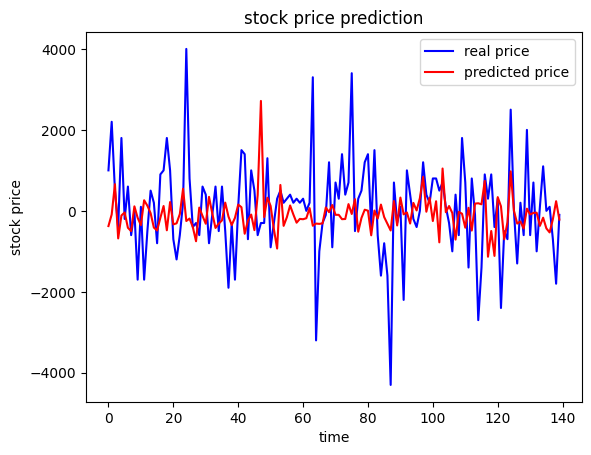

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
from keras.optimizers import Adam
from keras import backend as K

#시간을 줄이기 위해 데이터를 0~1 사이로 간소화
def MinMaxScaler(data):
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  return numerator / (denominator+1e-7) #0으로 나누지 않도록 작은 값 추가

df = pd.read_csv('/content/big.csv')

column_names = ['RSI_A000070', 'perb_A000070', 'CCI_A000070', 'MFI_A000070', 'KQ11', '종가_A023410', 'KS11', '종가_A089470',
        '종가_A016360', '종가_A016610', '종가_A060720', 'RSI_A036670', '종가_A036670']


x = df[column_names]
x= MinMaxScaler(x)
y = df[['종가_A000070']]

x = x.values.tolist()
y = y.values.tolist()

data_x = []
data_y = []
window_size = 10
#이전 10일(window_size)의 정보로 다음 날 종가를 예측
for i in range(len(y) - window_size):
  data_x.append(x[i:i+window_size])  #3차원-각 day 마다 2차원 정보(open,high,low,close,volume)
  data_y.append(y[i + window_size])  #2차원-각 day 마다 Close

#0.7 train 0.3 test
train_size = int(len(data_y) * 0.7)
trainX = np.array(data_x[0:train_size])
trainY = np.array(data_y[0:train_size])

test_size = len(data_y) - train_size
testX = np.array(data_x[train_size:])
testY = np.array(data_y[train_size:])

#model
model = Sequential()
model.add(LSTM (units=36, activation = 'relu', return_sequences=True, input_shape=(window_size,len(column_names))) )
model.add(Dropout(0.1))
model.add(Dense(units=32))
model.add(Dropout(0.1))
model.add(Dense(units=60))
model.add(Dropout(0.1))
model.add(Dense(units=20))
model.add(Dense(units=1))
model.summary()
'''
함수형 모델
'''===============================2. Model =============================='''
K.clear_session()

input_layer = Input(shape=(window_size, len(all_features)))

num_units = 224

layer_lstm_1 = LSTM(num_units, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(input_layer)
layer_lstm_1 = BatchNormalization()(layer_lstm_1)
layer_lstm_2 = LSTM(num_units, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(layer_lstm_1)
layer_lstm_2 = Dropout(0.05)(layer_lstm_2)
layer_lstm_3 = LSTM(num_units, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(layer_lstm_2)
layer_lstm_3 = BatchNormalization()(layer_lstm_3)
layer_lstm_4 = LSTM(num_units, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(layer_lstm_3)
layer_lstm_4 = Dropout(0.05)(layer_lstm_4)
layer_lstm_5 = LSTM(num_units, recurrent_regularizer=regularizers.l2(0.01))(layer_lstm_4)
layer_lstm_5 = BatchNormalization()(layer_lstm_5)

output_layer = Dense(1)(layer_lstm_5)
'''

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(trainX, trainY, epochs=1000, batch_size=40)
pred_y = model.predict(testX)

plt.figure()
plt.plot(testY, color='blue', label='real price')
# pred_y는 LSTM 에서 return_sequence=True로 했기 때문에, each time에 대한 것으로 3차원으로 return 된다.
# 즉, 원래 2차원 + time
plt.plot(pred_y[:, 0, 0],color='red', label='predicted price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

## LSTM - 함수형, 15일 한번에 예측

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import pandas as pd
import json
from sklearn.model_selection import train_test_split

#공식 데이터 가져오기
df = pd.read_csv('train.csv', encoding='cp949')
train_list = df['종목코드'][:2000].to_list()
df = df.pivot(index='일자', columns=['종목코드'], values=['종가','거래량','시가','고가','저가'])
df.columns = df.columns.map('_'.join).str.strip('_')
#변하지 않는 값들 상장폐지, 거래중지 등
zero_variance_columns = df.iloc[:, 1:].columns[df.iloc[:, 1:].var() == 0]
file_path = 'info_top15.json'
with open(file_path, 'r') as file:
    data = json.load(file)
df = pd.read_csv('big.csv')


#시간을 줄이기 위해 데이터를 0~1 사이로 간소화
def MinMaxScaler(data):
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  return numerator / (denominator+1e-7) #0으로 나누지 않도록 작은 값 추가

def learn_model(target):
    '''===============================1. Data =============================='''
    all_features = data['종가_'+target]
    x = df[all_features]
    x= MinMaxScaler(x)
    y = df[['종가_'+ target]]
    x = x.values.tolist()
    y = y.values.tolist()

    data_x = []
    data_y = []
    window_size = 30

    #이전 (window_size)의 정보로 다음 15일 종가를 예측
    for i in range(len(y) - window_size - 15):
        data_x.append(x[i:i+window_size])
        y_temp = []
        for j in range(i+window_size, i+ window_size+15):
            y_temp.append(y[j])
        data_y.append(y_temp)

    x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, random_state=66, test_size= 0.2, shuffle=False)
    x_val, x_test, y_val, y_test = train_test_split(x_test , y_test, random_state=66, test_size= 0.5, shuffle=False)
    '''===============================2. Model =============================='''
    K.clear_session()

    input_layer = Input(shape=(window_size, len(all_features)))

    num_units = 224

    layer_lstm_1 = LSTM(num_units, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(input_layer)
    layer_lstm_1 = BatchNormalization()(layer_lstm_1)
    layer_lstm_2 = LSTM(num_units, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(layer_lstm_1)
    layer_lstm_2 = Dropout(0.15)(layer_lstm_2)
    layer_lstm_3 = LSTM(num_units, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(layer_lstm_2)
    layer_lstm_3 = BatchNormalization()(layer_lstm_3)
    layer_lstm_4 = LSTM(num_units, return_sequences=True, recurrent_regularizer=regularizers.l2(0.01))(layer_lstm_3)
    layer_lstm_4 = Dropout(0.15)(layer_lstm_4)
    layer_lstm_5 = LSTM(num_units, recurrent_regularizer=regularizers.l2(0.01))(layer_lstm_4)
    layer_lstm_5 = BatchNormalization()(layer_lstm_5)

    output_layer = Dense(15)(layer_lstm_5)

    '''===============================3. Leaning =============================='''
    early_stopping = EarlyStopping(monitor='val_loss', patience=500, mode='min')
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    # print(model.summary())

    history = model.fit(x_train,y_train,epochs=400, batch_size=32,
                    validation_data=(x_val, y_val),callbacks=[early_stopping], verbose = 0)
    '''===============================4. Predict =============================='''


    '''
    plot_history(history) # 3단계
    pred_y = model.predict(x_test)

    n = 15  # Number of days to predict
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
    axes = axes.flatten()

    for i in range(n):
        axes[i].plot([y[i][0] for y in y_test], label='True')
        axes[i].plot([y[i] for y in pred_y], label='Predicted')
        axes[i].set_title(f"Day {i + 1}")
        axes[i].legend()

    for i in range(n, len(axes)):
        fig.delaxes(axes[i])

    fig.suptitle("Next 15 Days Stock Price Predictions", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()
    '''
    last_x = np.array(x[-window_size:])[np.newaxis, :, :]
    predictions = model.predict(last_x)

    return predictions



result = pd.DataFrame()

for i in range( len(train_list) - 1 ,0,-1):
    var = train_list[i]
    if var not in zero_variance_columns:
        print(var)
        result[var]  = learn_model(var).ravel()
    path = 'result' + str(j) + '.csv'
    result.to_csv(path, index=False)

result

## LSTM - classification (Increase, decrease)
캐글에서 돌린 코드 - 캐글에 5가지 분류, 2가지 분류로 15일 예측하기 등등 있다.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import pandas as pd
df = pd.read_csv('/kaggle/input/krx-contest-1/big.csv')

'''===============================1. Data =============================='''
#feature1_list = ['거래량_A000080','시가_A000080', '종가_A000080','고가_A000080','저가_A000080']
#feature2_list = ['SMA_A000080','RSI_A000080','CCI_A000080','stddev_A000080','perb_A000080','bw_A000080','MFI_A000080' ]
#feature3_list = [ 'KS11', 'KQ11', 'VIX']
#feature4_list = ['종가_A000140', '종가_A006360', '종가_A038390', '종가_A039130', '종가_A079160','저가_A000140', 'perb_A000080', 'RSI_A000140']

#all_features = feature1_list + feature2_list + feature3_list + featurelist4_list

all_features = [ 'RSI_A000080', 'perb_A000080', '고가_A000080',
       '저가_A000080', '종가_A000140', 'RSI_A000140', '저가_A000140', '종가_A006360',
       '종가_A038390', '종가_A035250', '종가_A079160', '종가_A024720', '종가_A039130',
       '종가_A034230', '종가_A032350', '종가_A007720', '종가_A080160', '종가_A006060',
       '종가_A023410', '종가_A010960', 'RSI_A006360', '종가_A003490', 'perb_A000140',
       '종가_A001680', 'KS11', '종가_A017810', '종가_A069960', '종가_A094850',
       '종가_A006730']



x = df[all_features]
x = x.values.tolist()
y = df[['종가_A000080']]
y_labels = np.where(y > 0, 1, 0)
y_labels = y_labels.flatten().tolist()


data_x = []
data_y = []
window_size = 40


for i in range(len(y_labels) - window_size):
    data_x.append(x[i:i+window_size])
    data_y.append(y_labels[i + window_size])

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, random_state=66, test_size= 0.2, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_test , y_test, random_state=66, test_size= 0.5, shuffle=False)



'''===============================2. Model =============================='''
K.clear_session()

input_layer = Input(shape=(window_size, len(all_features)))

num_units = 32

layer_lstm_1 = LSTM(num_units, return_sequences=True, recurrent_regularizer=regularizers.l2(0.03))(input_layer)
layer_lstm_1 = BatchNormalization()(layer_lstm_1)
layer_lstm_2 = LSTM(num_units, return_sequences=True, recurrent_regularizer=regularizers.l2(0.03))(layer_lstm_1)
layer_lstm_2 = Dropout(0.25)(layer_lstm_2)
layer_lstm_3 = LSTM(num_units, return_sequences=True, recurrent_regularizer=regularizers.l2(0.03))(layer_lstm_2)
layer_lstm_3 = BatchNormalization()(layer_lstm_3)
layer_lstm_4 = LSTM(num_units, return_sequences=True, recurrent_regularizer=regularizers.l2(0.03))(layer_lstm_3)
layer_lstm_4 = Dropout(0.25)(layer_lstm_4)
layer_lstm_5 = LSTM(num_units, recurrent_regularizer=regularizers.l2(0.03))(layer_lstm_4)
layer_lstm_5 = BatchNormalization()(layer_lstm_5)

output_layer = Dense(2, activation='sigmoid')(layer_lstm_5)


'''===============================3. Leaning =============================='''
early_stopping = EarlyStopping(monitor='val_loss', patience=30, mode='min')
model = Model(inputs=input_layer, outputs=output_layer)

from tensorflow.keras import optimizers

optimizer = optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())


history = model.fit(x_train,y_train,epochs=1000, batch_size=32,
                    validation_data=(x_val, y_val),callbacks=[early_stopping])
'''===============================4. Predict =============================='''

def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")


plot_history(history)

pred_y = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='real classification', alpha=0.5)
plt.scatter(range(len(pred_y)), np.argmax(pred_y, axis=1) , color='red', label='predicted classification', alpha=0.5)
plt.title('Stock Price Classification Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price Classification')
plt.legend()
plt.show

## grid search

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
from tensorflow.keras.optimizers import Adam

def build_train_evaluate_model(trainX, trainY, testX, testY, window_size, num_input, l1_strength, l2_strength, epochs, batch_size):
    # Build the model
    model = Sequential()
    model.add(LSTM(units=30,
                   activation='relu',
                   return_sequences=True,
                   input_shape=(window_size, num_input),
                   kernel_regularizer=l1_l2(l1=l1_strength, l2=l2_strength)))
    model.add(LSTM(units=8,
                   kernel_regularizer=l1_l2(l1=l1_strength, l2=l2_strength)))
    model.add(Dropout(0.2))
    model.add(Dense(units=52,
                    kernel_regularizer=l1_l2(l1=l1_strength, l2=l2_strength)))
    model.add(Dropout(0.2))
    model.add(Dense(units=64,
                    kernel_regularizer=l1_l2(l1=l1_strength, l2=l2_strength)))
    model.add(Dropout(0.2))
    model.add(Dense(units=50,
                    kernel_regularizer=l1_l2(l1=l1_strength, l2=l2_strength)))
    model.add(Dropout(0.2))
    model.add(Dense(units=52,
                    kernel_regularizer=l1_l2(l1=l1_strength, l2=l2_strength)))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)

    # Evaluate the model
    mse = model.evaluate(testX, testY)

    return mse



def MinMaxScaler(data):
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  return numerator / (denominator+1e-7) #0으로 나누지 않도록 작은 값 추가


##
dfx = df[['RSI_A078590', 'RSI_A063570', 'perb_A063570',
        '종가_A001810', 'KQ11', '종가_A089150',  '종가_A052600',
        'RSI_A052600', 'RSI_A001810', '종가_A214330', '종가_A025750', 'RSI_A089150',
        '종가_A006620', '종가_A192250', 'KS11', '종가_A253590', '종가_A096760',
        '종가_A021650']]

dfx= MinMaxScaler(dfx)
dfy = df[['종가_A063570']]

x = dfx.values.tolist()
y = dfy.values.tolist()

data_x = []
data_y = []

#이전 (window_size)의 정보로 다음 날 종가를 예측
for i in range(len(y) - window_size):
  _x = x[i:i+window_size] #day 0~9의 x
  _y = y[i + window_size] #day 10일의 y
  data_x.append(_x)  #3차원-각 day 마다 2차원 정보
  data_y.append(_y)  #2차원-각 day 마다 Close

#0.7 train 0.3 test
train_size = int(len(data_y) * 0.7)
trainX = np.array(data_x[0:train_size])
trainY = np.array(data_y[0:train_size])

test_size = len(data_y) - train_size
testX = np.array(data_x[train_size:])
testY = np.array(data_y[train_size:])


# Define the hyperparameters and their possible values
hyperparameters = {
    'window_size': [5, 10, 15, 20, 25],
    'num_input': [len(dfx.columns)],
    'l1_strength': [0.001, 0.01, 0.1],
    'l2_strength': [0.001, 0.01, 0.1],
    'epochs': [300, 400, 500],
    'batch_size': [20, 50, 100,200]
}

best_mse = float('inf')
best_hyperparameters = {}

# Perform grid search
for window_size in hyperparameters['window_size']:
    for l1_strength in hyperparameters['l1_strength']:
        for l2_strength in hyperparameters['l2_strength']:
            for epochs in hyperparameters['epochs']:
                for batch_size in hyperparameters['batch_size']:
                    print('oh')
                    mse = build_train_evaluate_model(trainX, trainY, testX, testY, window_size, num_input, l1_strength, l2_strength, epochs, batch_size)
                    if mse < best_mse:
                        best_mse = mse
                        best_hyperparameters = {
                            'window_size': window_size,
                            'l1_strength': l1_strength,
                            'l2_strength': l2_strength,
                            'epochs': epochs,
                            'batch_size': batch_size,
                            'num_input': num_input,
                        }
# Print the best hyperparameters and their corresponding MSE
print("Best Hyperparameters:")
print(best_hyperparameters)
print("Best MSE:", best_mse)

KeyError: ignored

## Kaggle에서 LSTM 학습시킨 모델 평가

In [ ]:
csv_file_2 = pd.read_csv("/content/result111~250.csv")
csv_file_1 = pd.read_csv("/content/result_1~110.csv")

# Ensure that both DataFrames have the same number of rows
if len(csv_file_1) == len(csv_file_2):
    # Concatenate the DataFrames column-wise
    concatenated_csv = pd.concat([csv_file_1, csv_file_2], axis=1)

    # Save the concatenated DataFrame to a new CSV file
    concatenated_csv.to_csv("result-250.csv", index=False)
else:
    print("The number of rows in both CSV files must be equal.")

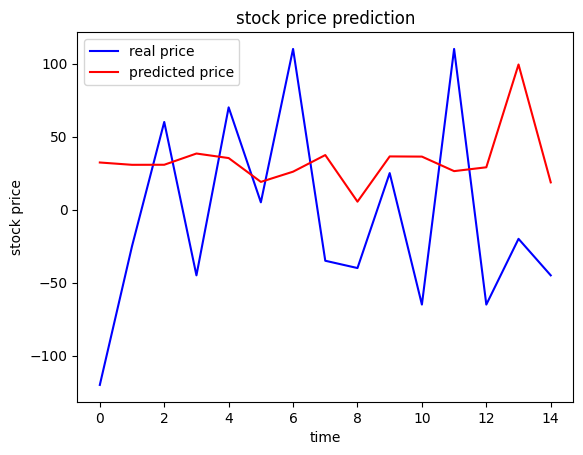

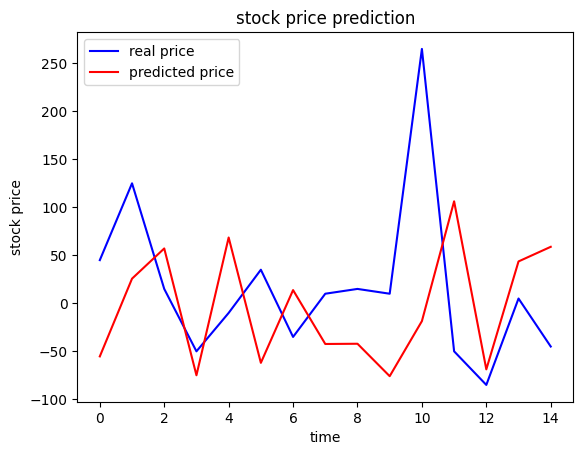

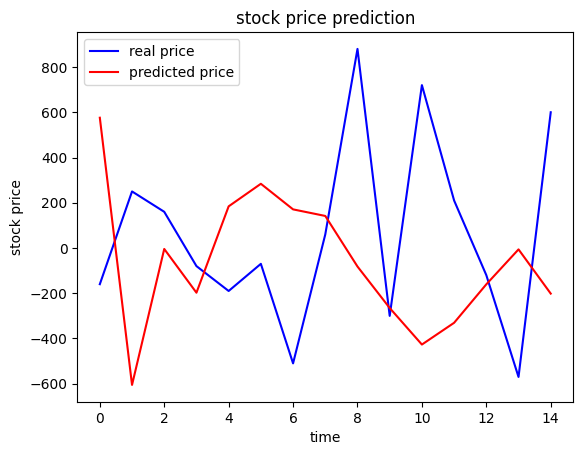

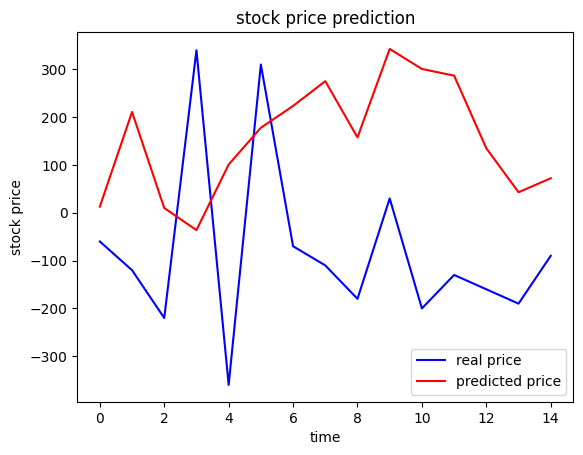

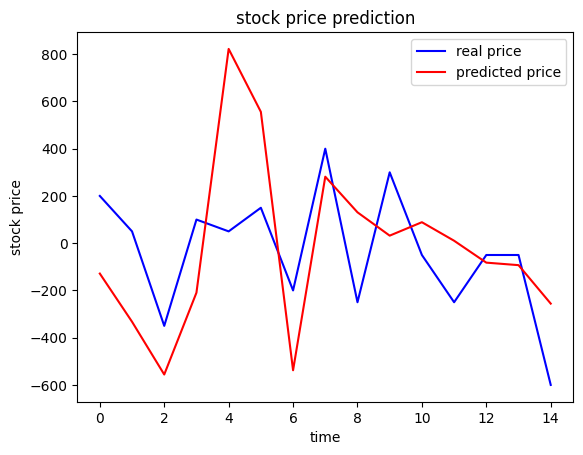

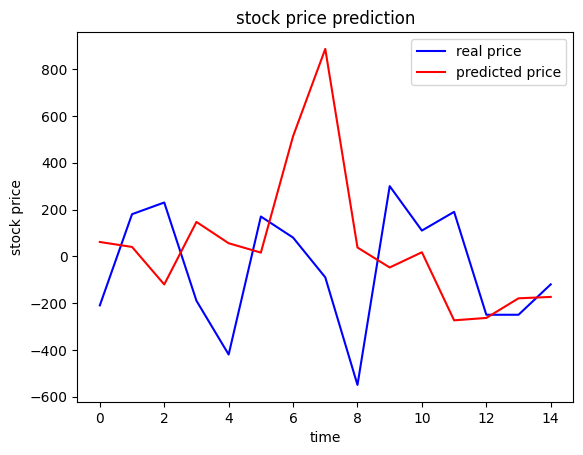

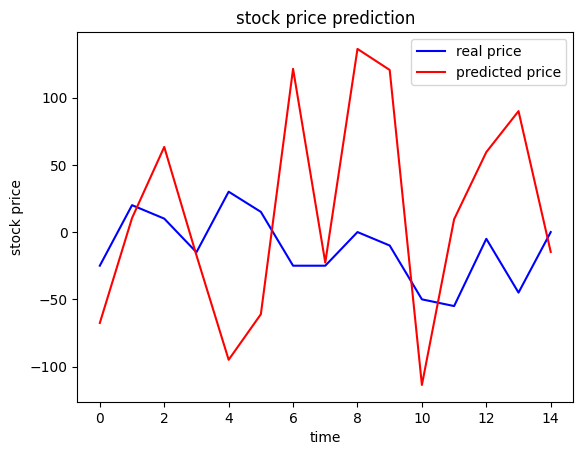

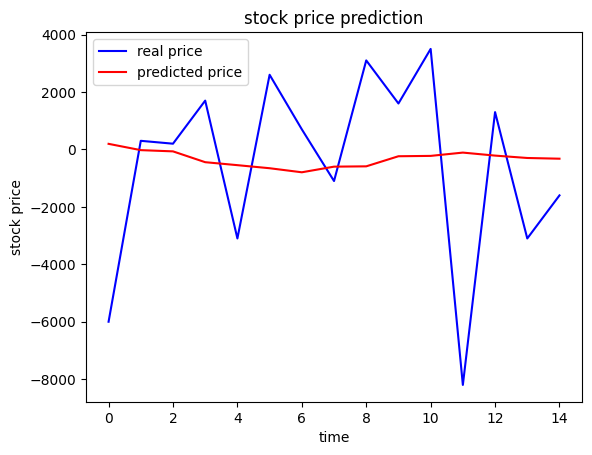

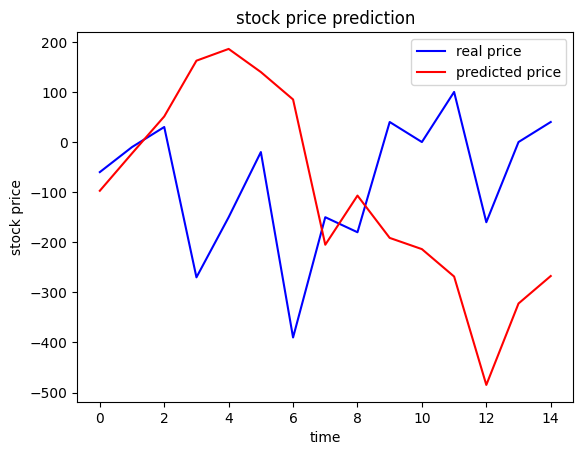

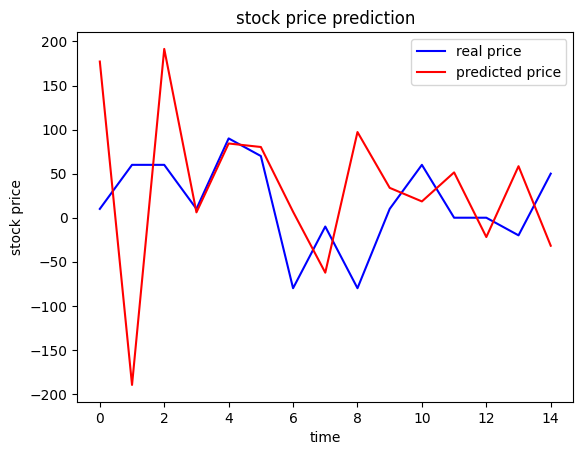

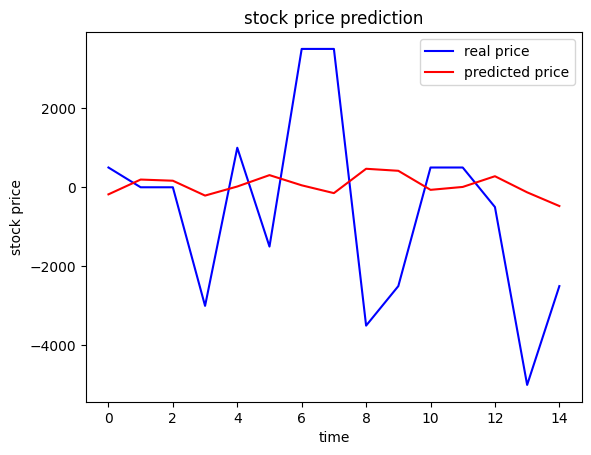

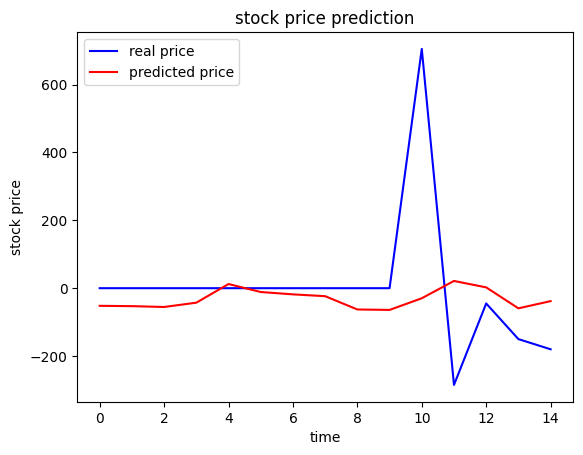

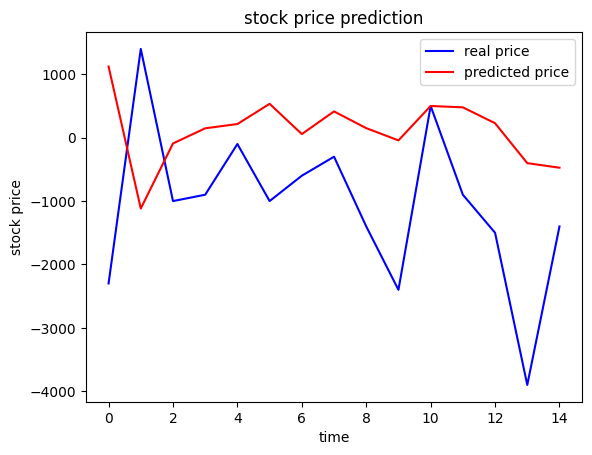

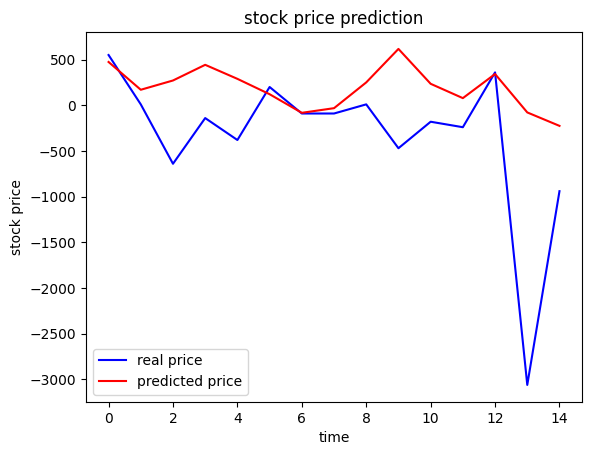

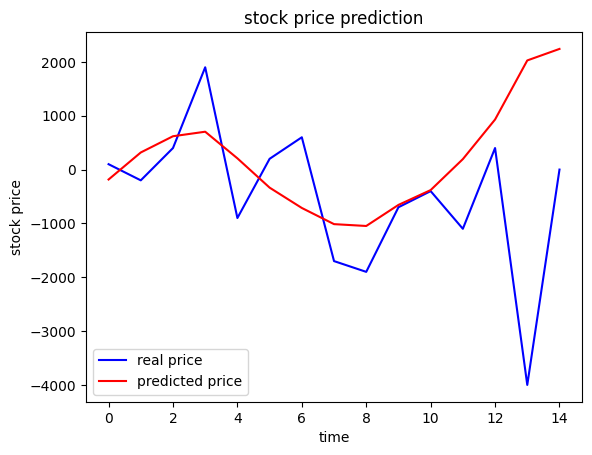

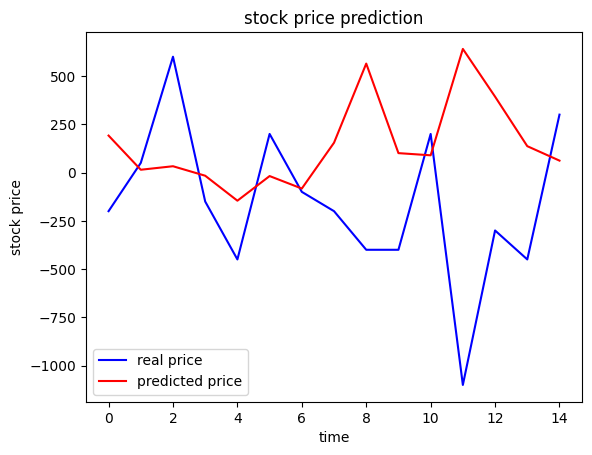

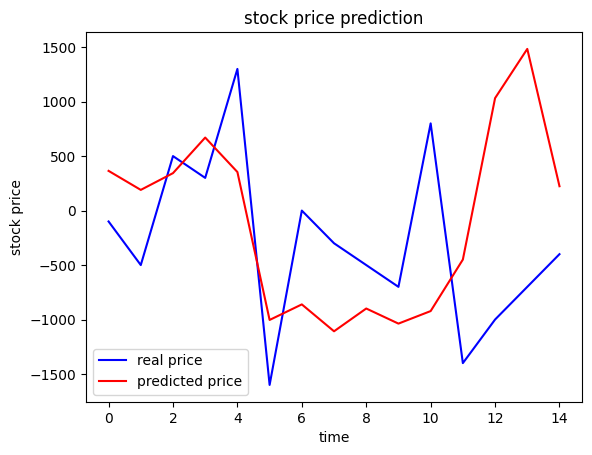

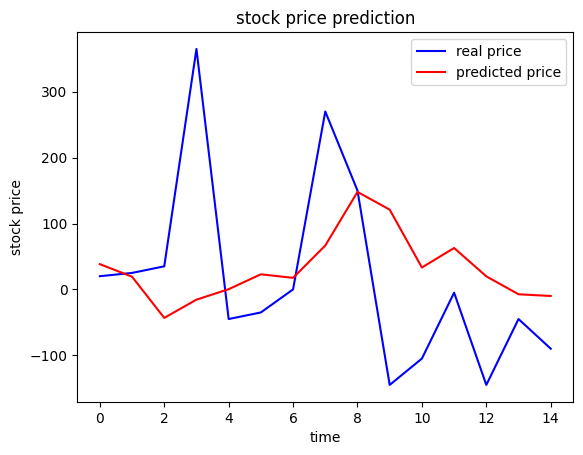

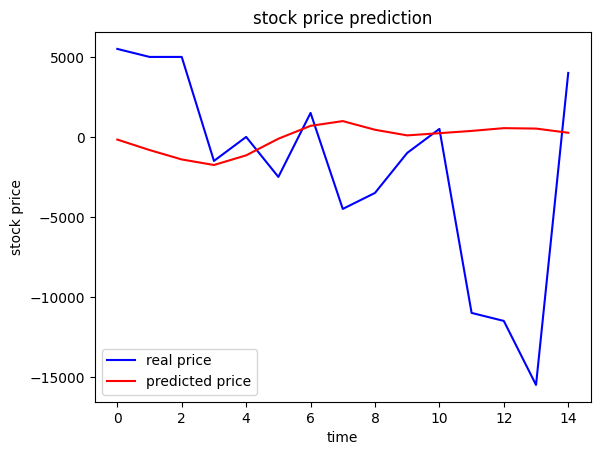

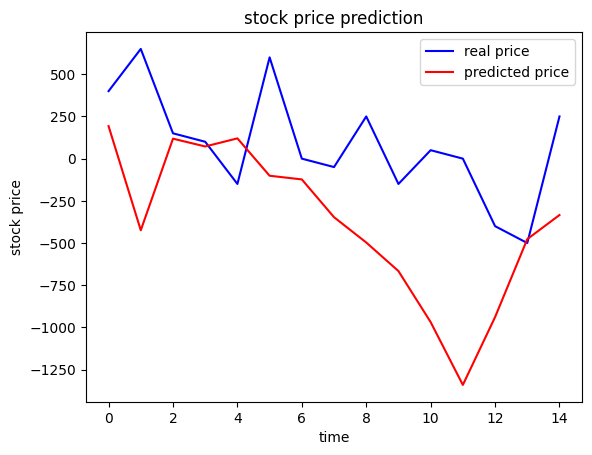

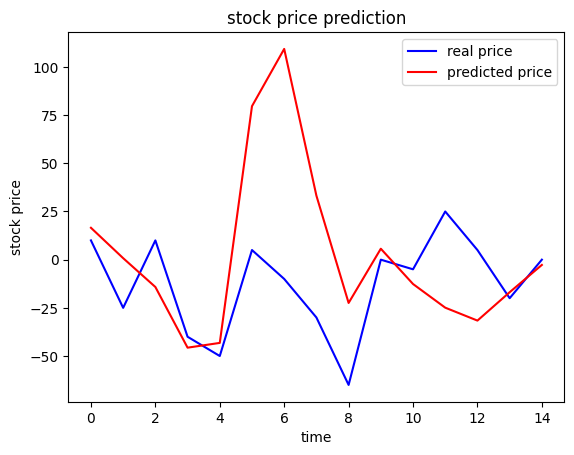

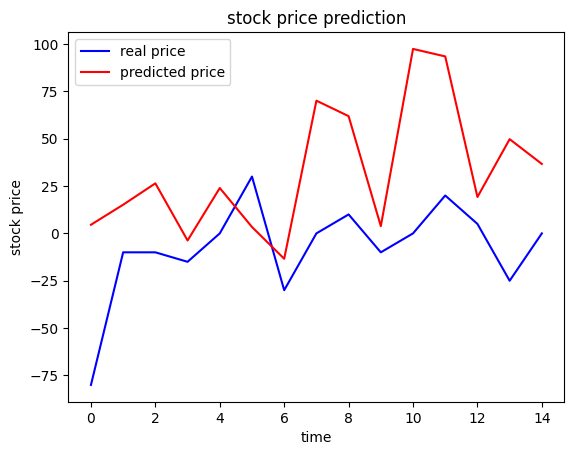

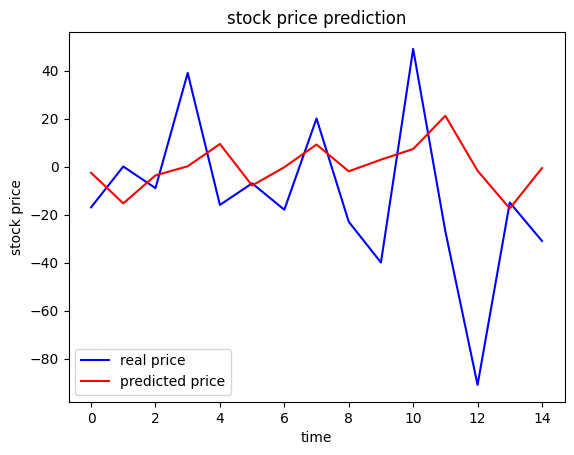

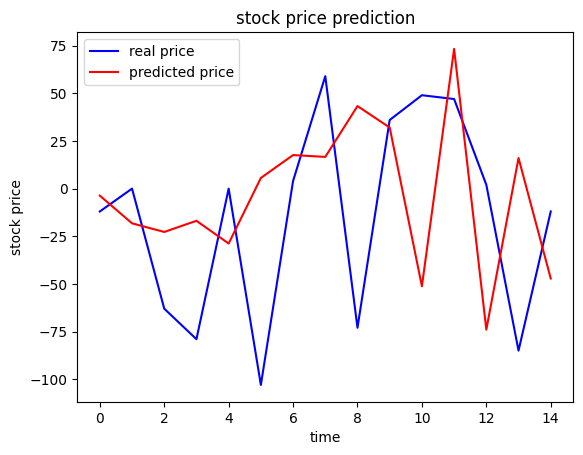

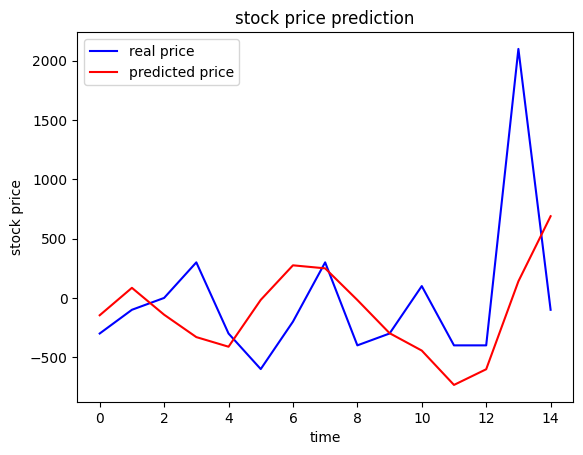

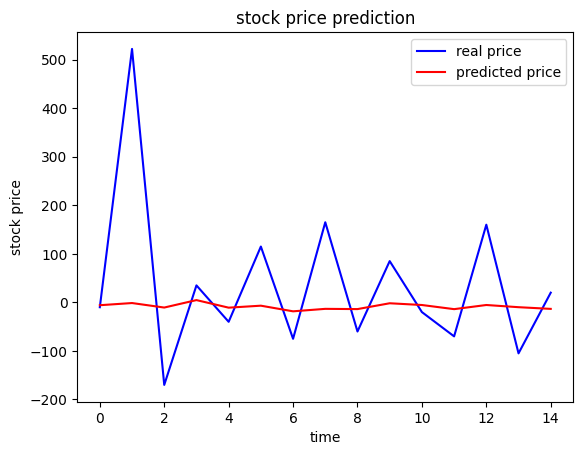

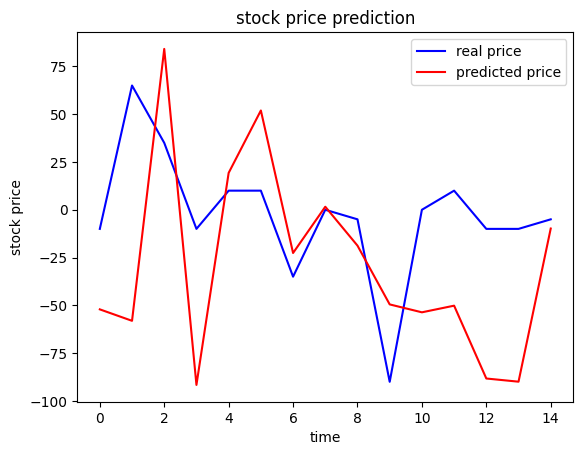

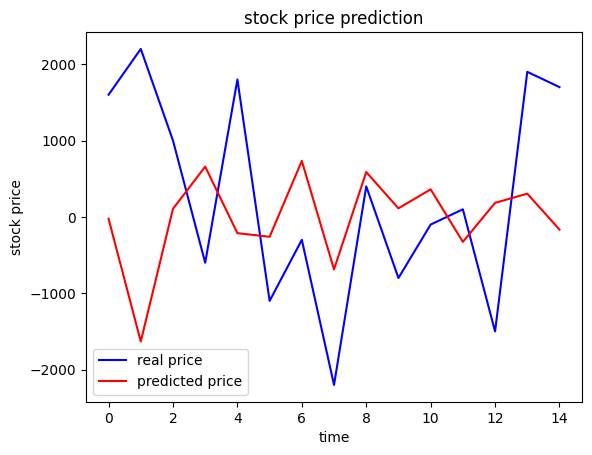

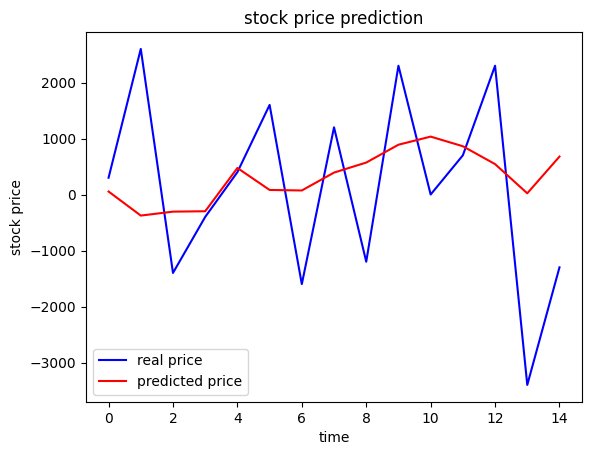

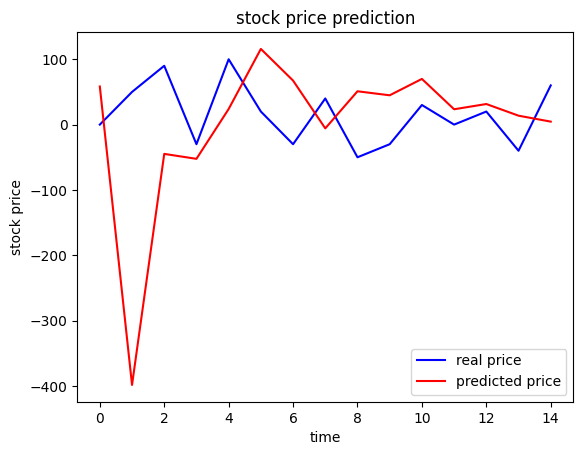

6291.031467209595
11401.139360839485
369665.44499198894
105167.77280835347
113817.00402992511
161273.5192630471
7592.431870495045
11388326.95676714
73307.49114534938
11182.302601926922
6067408.178686416
45585.84436368618
3287479.6027917373
838210.1862892029
3305092.662681922
390919.7752953615
1128316.098587182
21859.01677030888
47134376.408700734
410540.93201066065
2062.5585738393097
2706.016531126543
1218.9632588306806
4131.98285953989
407598.643217007
26764.189761685804
3257.7599721758716
2528902.8725793543
2720979.8710832647
18246.22151577654


In [ ]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
start_date = '2023-05-31'
last_date = '2023-06-22'

mse_list = []

for i in range(0,30):
  var = train_list[i]
  data = fdr.DataReader( var[1:] , start_date, last_date)['Close']
  data = data.diff()
  data =data.dropna()
  data_np = data.reset_index(drop=True).to_numpy()
  result_np = result.iloc[:, i].reset_index(drop=True).to_numpy()
  mse = mean_squared_error(data_np, result_np)
  mse_list.append(mse)
  plt.figure()
  plt.plot(data.reset_index(drop=True), color='blue', label='real price')
  plt.plot(result.iloc[:, i].reset_index(drop=True), color='red', label='predicted price')
  plt.title('stock price prediction')
  plt.xlabel('time')
  plt.ylabel('stock price')
  plt.legend()
  plt.show()

for x in mse_list:
  print(x)

# 시도 2 샤프지수의 변화로 예측하기

## 데이터 전처리 - 1 샤프지수 자체

In [ ]:
'''===================== HyperParameter =================='''
#지난 window_size_sharpe 일 동안의 샤프지수를 기록
window_size_sharpe = 30
#LSTM - 지난 window_size 일 동안의 정보를 가지고 다음 날을 예측
window_size = 20
'''===================== HyperParameter =================='''

#공식 데이터 가져오기
df = pd.read_csv('/content/train.csv', encoding='cp949')
#train_list = train['종목코드'][:2000].to_list() # 종목코드
train_list = df['종목코드'].unique()

#행열 바꾸기
df = df.pivot(index='일자', columns=['종목코드'], values=['종가'])

#level1 종가 level2 종목명 => 종가_종목명
df.columns = df.columns.map('_'.join).str.strip('_')

#index datetime 으로만들어 이후 외부 데이터와 결합
df.index = pd.to_datetime(df.index,format = '%Y%m%d')

#수익률
returns = ( df / df.shift(window_size_sharpe - 1)) - 1
#변동성
stdev = df.rolling(window_size_sharpe).std()

#sharp index
df2 = (returns - 0.035) / (stdev )

df2 = df2.dropna()
df2 = df2.reset_index(drop=True)
columns_list = df2.columns.to_list()

dfx = df2
dfy = df2

num_input = len(dfx.columns)
num_output = len(dfy.columns)

x = dfx.values.tolist()
y = dfy.values.tolist()

data_x = []
data_y = []

#이전 (window_size)의 정보로 다음 날 종가를 예측
for i in range(len(y) - window_size):
  _x = x[i:i+window_size] #day 0~9의 x
  _y = y[i + window_size] #day 10일의 y
  data_x.append(_x)  #3차원-각 day 마다 2차원 정보
  data_y.append(_y)  #2차원-각 day 마다 Close

# train / test / validation
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, random_state=66, test_size= 0.2, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_test , y_test, random_state=66, test_size= 0.5, shuffle=False)

#숫자 너무 작으면 손실 안보인다.
df2 = df2 * 100000


has_nan = df2.isna().any().any()

# Print the result
print(f"DataFrame contains NaN values: {has_nan}")

df2

DataFrame contains NaN values: False


종가_A000020  종가_A000040  종가_A000050  종가_A000070  종가_A000080  종가_A000100  \
0     -0.782986  128.253233  -20.712396   -3.805510   -9.417979   -8.136421   
1     -2.057346   33.299782  -21.745381   -3.355056   -9.364996   -6.302131   
2     -4.750721   60.537304  -26.386329   -3.550557   -8.734077   -6.480482   
3     -4.820341   87.719041  -24.919173   -3.544263   -7.217124   -5.279484   
4    -11.346249   96.875947  -24.754263   -3.277551   -7.974414   -5.508930   
..          ...         ...         ...         ...         ...         ...   
174   20.283718  191.772459    5.630108   -2.696174    3.327555    0.650764   
175   21.299743  184.747158    0.806999   -1.726093    5.731713    1.964359   
176   10.690460  155.387475   12.948740   -1.813083    5.354440   -1.315914   
177    7.337601  154.188839   11.454501   -2.570344    5.739220    0.693265   
178    7.581482  165.399265    7.141849   -2.779510    3.091627    0.719482   

     종가_A000120  종가_A000140  종가_A000150  종가_A000180  ...  종가_A363280  \
0      0.555435  -19.177203    3.984461  -33.812415  ...    1.743804   
1      1.026410  -19.782666    2.617505  -63.533382  ...   12.154235   
2      0.717734  -19.888877    4.213673  -48.858374  ...   13.886476   
3      0.974575  -18.298239    3.851723  -37.149682  ...   13.453602   
4      1.181666  -20.028192    0.711670  -63.396037  ...   10.598604   
..          ...         ...         ...         ...  ...         ...   
174    1.537814  -11.206257    1.359961  114.397983  ...    6.580089   
175    0.873511   -4.986377    1.499962   76.743846  ...    6.731744   
176    0.321956   -6.704952    1.384395   59.691221  ...    3.570712   
177   -0.159450  -11.052379    1.238946   54.400599  ...    2.822673   
178   -0.378396   -7.734518    0.618673   79.489861  ...    3.109864   

     종가_A365590  종가_A368770  종가_A369370  종가_A373200  종가_A375500  종가_A378850  \
0     -6.122084 -205.922615   45.273332  -11.816359    1.289243  -11.605153   
1     -2.282258  -84.636370   37.432879   -5.712473    1.053039   -4.215700   
2      1.551544 -154.290671   39.874644  -17.153455    0.619854   -1.000576   
3      5.372539  -88.637303   63.549967   40.679805    0.508140    1.537674   
4      1.548423  -16.793584   76.224700   59.727825    0.301424    5.251319   
..          ...         ...         ...         ...         ...         ...   
174    4.288396 -111.973161   40.656131  -20.410559    1.933072   36.832098   
175   16.014999  -86.510645   41.864838    2.567293    2.403673   45.009509   
176   31.184724  -66.420576   32.316044  -31.352447    2.416326   27.141002   
177   11.782436  -59.946861   40.825824   68.586375    2.404443   38.669328   
178   41.076936  -51.378568   34.660143   66.750211    1.750536   24.877944   

     종가_A383220  종가_A383310  종가_A383800  
0      0.208748    2.026002  -16.947477  
1      0.407554    2.357059   -4.049133  
2      0.294171    2.161172    1.219379  
3      0.380421    1.553144    3.118179  
4      0.236679    2.368668  -10.998610  
..          ...         ...         ...  
174   -0.368212    3.871137  -38.070361  
175   -0.350933    3.350253  -31.221950  
176   -0.301807    1.631907  -48.329303  
177   -0.194750    0.413492  -49.591697  
178   -0.221620    2.108389  -54.633487  

[179 rows x 2000 columns]

## 데이터 전처리 - 2  샤프지수 순위

In [ ]:
'''===================== HyperParameter =================='''
#지난 window_size_sharpe 일 동안의 샤프지수를 기록
window_size_sharpe = 7
#LSTM - 지난 window_size 일 동안의 정보를 가지고 다음 날을 예측
window_size = 50
'''===================== HyperParameter =================='''

########## 공식 데이터 가져오기
df = pd.read_csv('/content/train.csv', encoding='cp949')
#train_list = train['종목코드'][:2000].to_list() # 종목코드
train_list = df['종목코드'].unique()

#행열 바꾸기
df = df.pivot(index='일자', columns=['종목코드'], values=['종가'])

#level1 종가 level2 종목명 => 종가_종목명
df.columns = df.columns.map('_'.join).str.strip('_')

#index datetime 으로만들어 이후 외부 데이터와 결합
df.index = pd.to_datetime(df.index,format = '%Y%m%d')

#수익률
returns = ( df / df.shift(window_size_sharpe - 1)) - 1
#변동성
stdev = df.rolling(window_size_sharpe).std()

#sharp index
df2 = (returns - 3.5) / (stdev )

df2 = df2.dropna()
df2 = df2.reset_index(drop=True)
columns_list = df2.columns.to_list()

'''===============순위로 바꾸어주는 부분 !!================'''
array = np.array(df2)
array = array.argsort()
df2 = pd.DataFrame(array)
'''===============순위로 바꾸어주는 부분 !!================'''

dfx = df2/2000 # Minmaxscalar 대신 2,000으로 나눠줌으로써 순수 손으로 정규화
dfy = df2 # 정규화 하지 않은 0~1999 순위 데이터 예측

num_input = len(dfx.columns)
num_output = len(dfy.columns)

x = dfx.values.tolist()
y = dfy.values.tolist()

data_x = []
data_y = []

#이전 (window_size)의 정보로 다음 날 종가를 예측
for i in range(len(y) - window_size):
  _x = x[i:i+window_size] #day 0~9의 x
  _y = y[i + window_size] #day 10일의 y
  data_x.append(_x)  #3차원-각 day 마다 2차원 정보
  data_y.append(_y)  #2차원-각 day 마다 Close

# train / test / validation
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, random_state=66, test_size= 0.2, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_test , y_test, random_state=66, test_size= 0.5, shuffle=False)

has_nan = df2.isna().any().any()

# Print the result
print(f"DataFrame contains NaN values: {has_nan}")
df2

DataFrame contains NaN values: False


0     1     2     3     4     5     6     7     8     9     ...  1990  \
0    1537   458  1508  1013  1955   388  1113  1871   146  1152  ...   712   
1    1871   413  1013   458  1968  1062   809  1343  1925  1955  ...   399   
2     943  1343  1506  1508  1519  1062  1013  1537   564  1925  ...  1867   
3    1537  1352   564   943  1519  1113   912  1152  1343   686  ...  1484   
4     164   396  1774  1537   817  1541  1968  1762   533  1057  ...  1484   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
197   661  1645  1295  1774  1641   686  1932  1368  1784  1508  ...   883   
198  1508   273   817   809  1113  1774   686  1784  1352  1641  ...  1865   
199   388   943   564   301  1113  1932   164  1641  1645   892  ...  1820   
200   661   645   406   564  1494  1295   892  1152  1641  1774  ...  1865   
201  1113  1541   458   817  1537  1508  1506   948   943  1494  ...  1484   

     1991  1992  1993  1994  1995  1996  1997  1998  1999  
0    1690  1614  1864  1484  1865  1874   173   145  1453  
1    1614  1865  1864  1484  1453  1997   145  1874   173  
2     399  1614  1864  1484  1865   884  1997   173  1874  
3     883   687  1864   270   173   884  1865  1997  1874  
4     687   145  1864   884  1997   270   883  1874  1865  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
197  1997   270    32   884  1632   919   145   477   997  
198   145    32   883   884  1997   919  1632   270   477  
199   883  1030   255  1632  1997   919  1867   270   477  
200  1820   255  1632  1030   883  1997  1867   270   477  
201  1865  1632   255  1030  1997   477   883   270  1867  

[202 rows x 2000 columns]

## 데이터 전처리 - 3 샤프지수 변화

In [ ]:
'''===================== HyperParameter =================='''
#지난 window_size_sharpe 일 동안의 샤프지수를 기록
window_size_sharpe = 30
#LSTM - 지난 window_size 일 동안의 정보를 가지고 다음 날을 예측
window_size = 15
'''===================== HyperParameter =================='''

#공식 데이터 가져오기
df = pd.read_csv('/content/train.csv', encoding='cp949')
#train_list = train['종목코드'][:2000].to_list() # 종목코드
train_list = df['종목코드'].unique()

#행열 바꾸기
df = df.pivot(index='일자', columns=['종목코드'], values=['종가'])

#level1 종가 level2 종목명 => 종가_종목명
df.columns = df.columns.map('_'.join).str.strip('_')

#index datetime 으로만들어 이후 외부 데이터와 결합
df.index = pd.to_datetime(df.index,format = '%Y%m%d')

#수익률
returns = ( df / df.shift(window_size_sharpe - 1)) - 1
#변동성
stdev = df.rolling(window_size_sharpe).std()

#sharp index
df2 = (returns - 0.035) / ( stdev + 1e-7)
df2 = df2.diff()
df2 = df2.dropna()


df2 = df2.reset_index(drop=True)
columns_list = df2.columns.to_list()

dfx = df2
dfy = df2

num_input = len(dfx.columns)
num_output = len(dfy.columns)

x = dfx.values.tolist()
y = dfy.values.tolist()

data_x = []
data_y = []

#이전 (window_size)의 정보로 다음 날 종가를 예측
for i in range(len(y) - window_size):
  _x = x[i:i+window_size] #day 0~9의 x
  _y = y[i + window_size] #day 10일의 y
  data_x.append(_x)  #3차원-각 day 마다 2차원 정보
  data_y.append(_y)  #2차원-각 day 마다 Close

# train / test / validation
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, random_state=66, test_size= 0.2, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_test , y_test, random_state=66, test_size= 0.5, shuffle=False)


has_nan = df2.isna().any().any()

# Print the result
print(f"DataFrame contains NaN values: {has_nan}")

df2

DataFrame contains NaN values: False


종가_A000020  종가_A000040  종가_A000050    종가_A000070    종가_A000080  \
0   -1.274360e-05   -0.000950   -0.000010  4.504545e-06  5.298341e-07   
1   -2.693375e-05    0.000272   -0.000046 -1.955011e-06  6.309188e-06   
2   -6.961975e-07    0.000272    0.000015  6.293326e-08  1.516953e-05   
3   -6.525908e-05    0.000092    0.000002  2.667124e-06 -7.572901e-06   
4    5.159017e-05   -0.000039   -0.000030  1.354070e-06 -3.645801e-06   
..            ...         ...         ...           ...           ...   
459  1.752133e-04   -0.000217    0.000065  6.856219e-06  1.264986e-05   
460 -1.183328e-04    0.000374    0.000018 -2.616100e-06 -3.442752e-06   
461  2.261822e-05   -0.001189   -0.000003 -1.403234e-06 -9.883500e-07   
462 -6.869955e-05   -0.005058    0.000003 -2.739021e-05 -9.698955e-06   
463 -7.058254e-05   -0.001487   -0.000009 -7.951678e-06 -5.545945e-05   

     종가_A000100  종가_A000120  종가_A000140    종가_A000150  종가_A000180  ...  \
0      0.000018    0.000005   -0.000006 -1.366955e-05   -0.000297  ...   
1     -0.000002   -0.000003   -0.000001  1.596167e-05    0.000147  ...   
2      0.000012    0.000003    0.000016 -3.619501e-06    0.000117  ...   
3     -0.000002    0.000002   -0.000017 -3.140053e-05   -0.000262  ...   
4     -0.000008   -0.000002   -0.000012  2.945409e-07   -0.000175  ...   
..          ...         ...         ...           ...         ...  ...   
459   -0.000011    0.000013    0.000001 -3.922311e-06    0.000537  ...   
460   -0.000024   -0.000002    0.000099  1.229317e-05   -0.000814  ...   
461   -0.000036   -0.000018   -0.000071 -8.710986e-06   -0.000544  ...   
462   -0.000012    0.000002   -0.000006 -1.002954e-05   -0.000476  ...   
463    0.000018   -0.000017   -0.000026  2.303367e-06   -0.000045  ...   

     종가_A363280  종가_A365590  종가_A368770  종가_A369370  종가_A373200    종가_A375500  \
0      0.000104    0.000038    0.001213   -0.000078    0.000061 -2.362040e-06   
1      0.000017    0.000038   -0.000697    0.000024   -0.000114 -4.331847e-06   
2     -0.000004    0.000038    0.000657    0.000237    0.000578 -1.117144e-06   
3     -0.000029   -0.000038    0.000718    0.000127    0.000190 -2.067156e-06   
4     -0.000004    0.000076    0.000701    0.000124    0.000264  4.537707e-07   
..          ...         ...         ...         ...         ...           ...   
459    0.000117   -0.000641    0.000100    0.001147   -0.000006  3.254306e-05   
460    0.000038   -0.000335   -0.000143   -0.000062   -0.000118 -3.788214e-06   
461   -0.000122   -0.000356   -0.000127   -0.000315    0.000060 -3.005470e-05   
462   -0.000151   -0.000042   -0.000208   -0.000223   -0.000036  3.509366e-07   
463   -0.000077   -0.000263   -0.000026   -0.000415   -0.000027  6.837318e-06   

     종가_A378850    종가_A383220    종가_A383310  종가_A383800  
0      0.000074  1.988060e-06  3.310568e-06    0.000129  
1      0.000032 -1.133831e-06 -1.958864e-06    0.000053  
2      0.000025  8.625005e-07 -6.080281e-06    0.000019  
3      0.000037 -1.437415e-06  8.155240e-06   -0.000141  
4     -0.000010  1.112355e-06  4.211806e-06   -0.000116  
..          ...           ...           ...         ...  
459   -0.000209  5.927150e-06 -8.216740e-06    0.000011  
460    0.000079 -1.458140e-05 -7.443307e-08   -0.000007  
461   -0.000306 -3.668619e-07  3.264386e-05   -0.000175  
462   -0.000118  5.598909e-06 -2.327272e-05   -0.000003  
463    0.000032 -5.101163e-06 -8.154561e-06    0.000037  

[464 rows x 2000 columns]

##  모델1 (LSTM, 하루 예측, 다소 복잡)

In [ ]:
'''================ model ================'''
l2_strength = 0.001
num_units = 2000

K.clear_session()

input_layer = Input(shape=(window_size, num_input) )

layer_lstm_1 = LSTM(200,activation='relu', return_sequences=True, recurrent_regularizer=regularizers.l2(l2_strength))(input_layer)
layer_lstm_1 = BatchNormalization()(layer_lstm_1)
layer_lstm_2 = LSTM(400,activation='relu',  return_sequences=True, recurrent_regularizer=regularizers.l2(l2_strength))(layer_lstm_1)
layer_lstm_2 = Dropout(0.02)(layer_lstm_2)
layer_lstm_3 = LSTM(800, return_sequences=False, recurrent_regularizer=regularizers.l2(l2_strength))(layer_lstm_2)
layer_lstm_3 = BatchNormalization()(layer_lstm_3)
layer_lstm_4 = Dense(1000, activation='relu')(layer_lstm_3)
layer_lstm_4 = Dropout(0.02)(layer_lstm_4)
layer_lstm_5 = Dense(1200, activation='relu')(layer_lstm_4)
layer_lstm_5 = BatchNormalization()(layer_lstm_5)

output_layer = Dense(num_output)(layer_lstm_5)

model = Model(inputs=input_layer, outputs=output_layer)

print(model.summary())

'''================ Learn ================'''
early_stopping = EarlyStopping(monitor='val_loss', patience=1000, mode='min')
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
history = model.fit(x_train,y_train,epochs=1000, batch_size=32,
                    validation_data=(x_val, y_val),callbacks=[early_stopping])

2/2 [==============================] - 1s 33ms/step


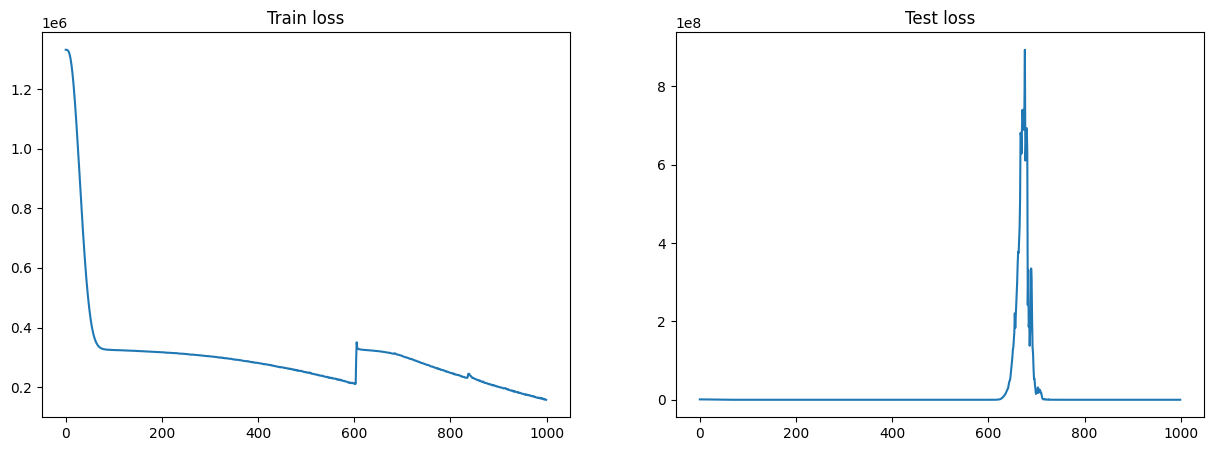

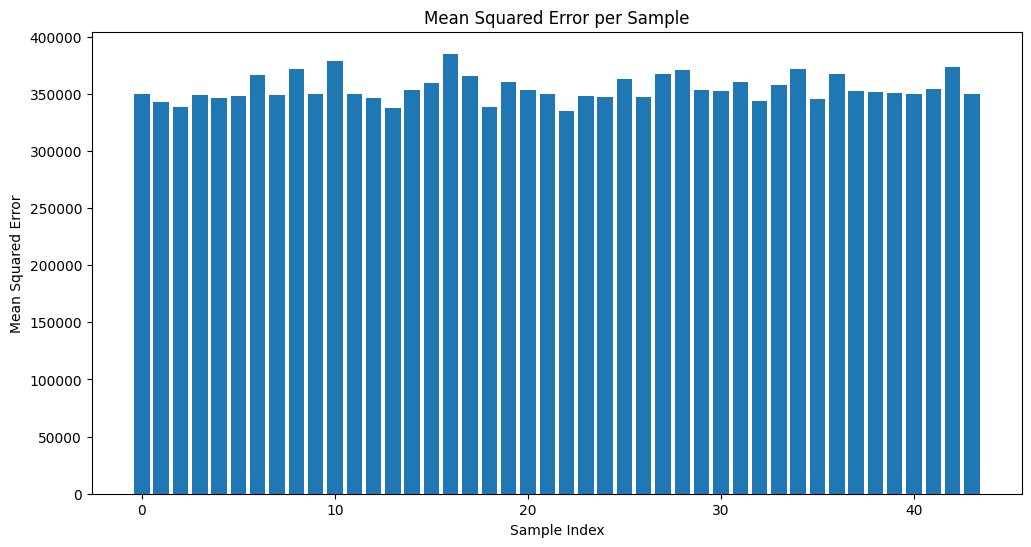

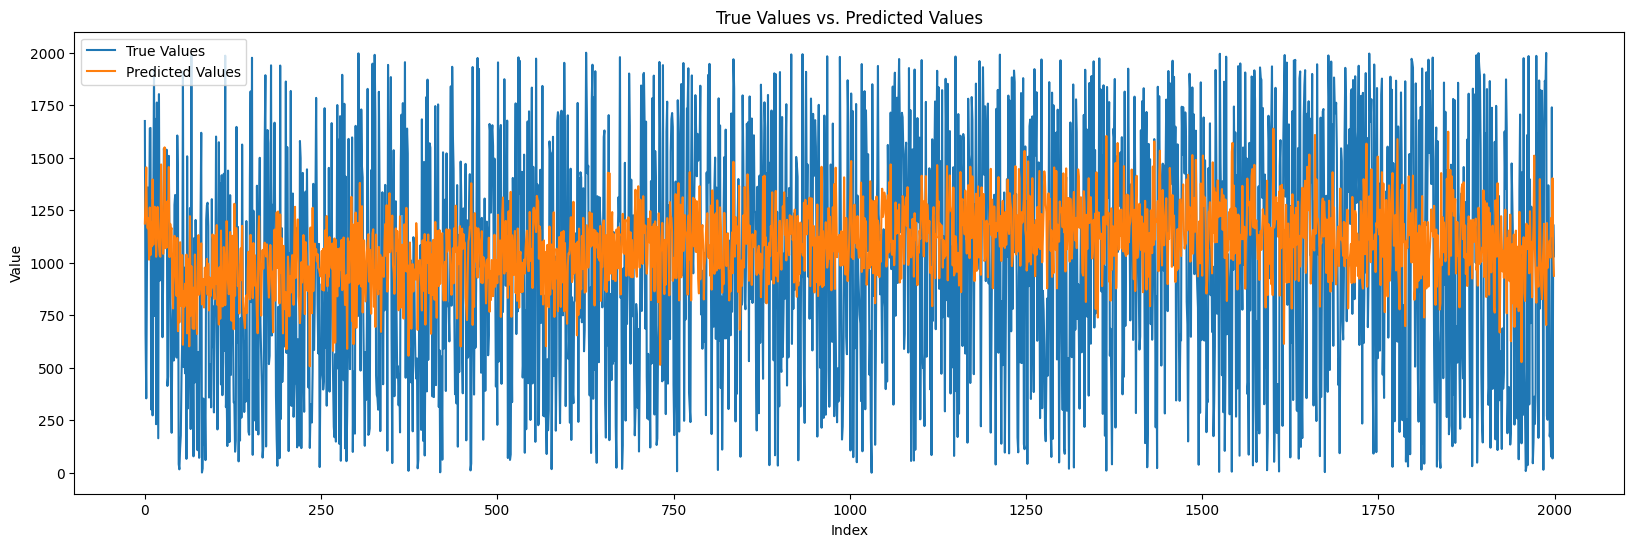

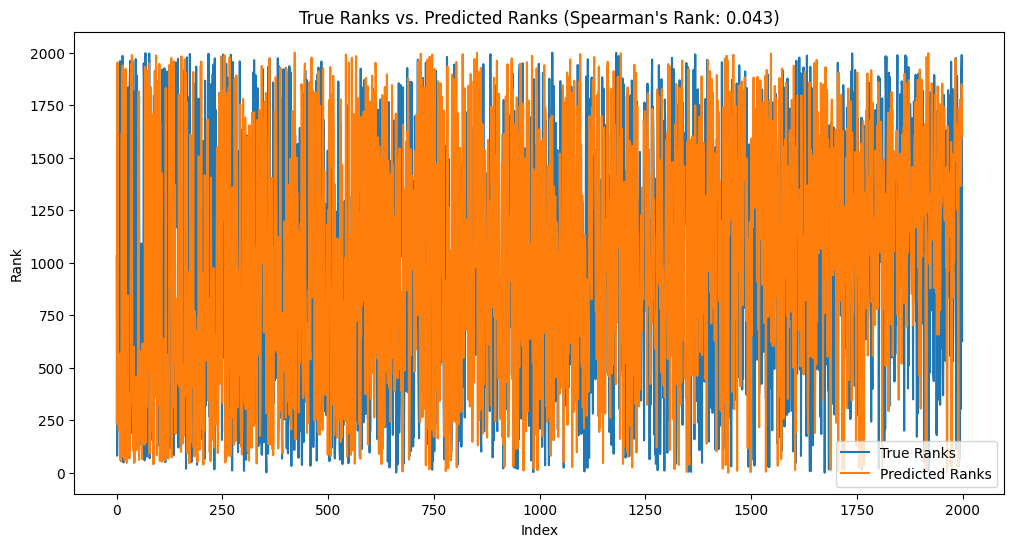

Average Spearman's Rank Correlation: 0.021712812041839374


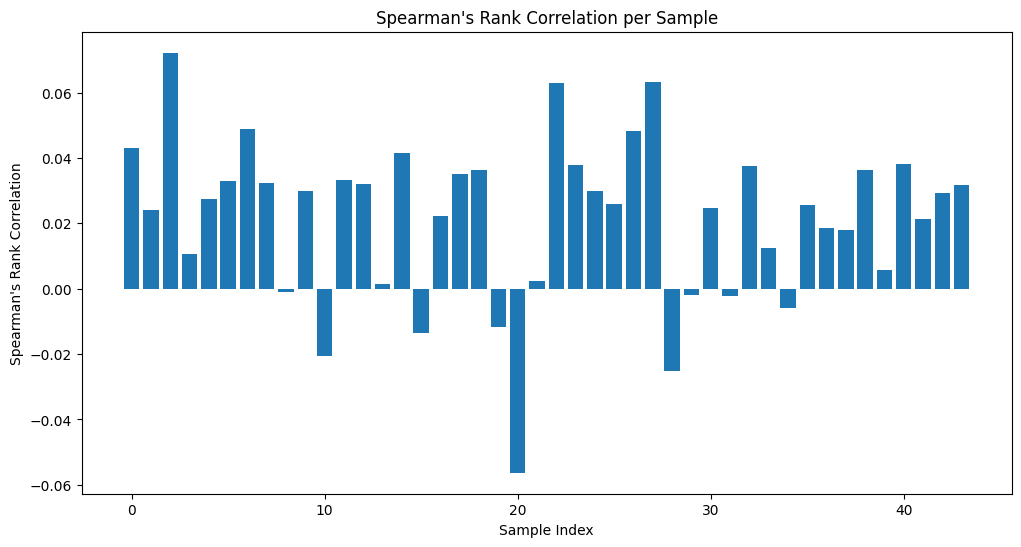

In [ ]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    plt.savefig('sample.png')

plot_history(history) #
pred_y = model.predict(x_test)
sample_index = 0

y_test = np.array(y_test)
# calculate the MSE for each sample
mse_per_sample = np.mean((y_test - pred_y) ** 2, axis=1)

plt.figure(figsize=(12, 6))
plt.bar(np.arange(y_test.shape[0]), mse_per_sample)
plt.xlabel('Sample Index')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error per Sample')
plt.show()


import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

sample_index = 0

plt.figure(figsize=(20, 6))
plt.plot(y_test[sample_index], label='True Values')
plt.plot(pred_y[sample_index], label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('True Values vs. Predicted Values')
plt.legend()
plt.show()

# Get the true and predicted ranks
true_ranks = np.argsort(y_test[sample_index])
predicted_ranks = np.argsort(pred_y[sample_index])

# Calculate the Spearman's rank correlation coefficient
coeff, _ = stats.spearmanr(true_ranks, predicted_ranks)

plt.figure(figsize=(12, 6))
plt.plot(true_ranks, label='True Ranks')
plt.plot(predicted_ranks, label='Predicted Ranks')
plt.xlabel('Index')
plt.ylabel('Rank')
plt.title(f'True Ranks vs. Predicted Ranks (Spearman\'s Rank: {coeff:.3f})')
plt.legend()
plt.show()

coeffs = []
# Calculate the Spearman's rank correlation for each sample
for i in range(y_test.shape[0]):
    true_ranks = np.argsort(y_test[i])
    predicted_ranks = np.argsort(pred_y[i])
    coeff, _ = stats.spearmanr(true_ranks, predicted_ranks)
    coeffs.append(coeff)

# Calculate and print the average Spearman's rank correlation
print("Average Spearman's Rank Correlation:", np.mean(coeffs))

# Visualize the Spearman's rank correlations using a bar chart
plt.figure(figsize=(12, 6))
plt.bar(np.arange(y_test.shape[0]), coeffs)
plt.xlabel('Sample Index')
plt.ylabel('Spearman\'s Rank Correlation')
plt.title('Spearman\'s Rank Correlation per Sample')
plt.show()

## 모델 2 (LSTM, 하루 예측, 매우 간단)

In [ ]:
from keras import initializers
from keras.optimizers import Adam
from keras.layers import Conv1D

learning_rate = 0.001
clip_value = 1.0
l2_strength = 0.001
num_units = 256
'''================ model ================'''
K.clear_session()

input_layer = Input(shape=(window_size, num_input) )

conv1d_layer = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(input_layer)
conv1d_dropout = Dropout(0.02)(conv1d_layer)
layer_lstm_1 = LSTM(num_units, return_sequences=True, recurrent_regularizer=regularizers.l2(l2_strength), recurrent_dropout=0.2)(conv1d_dropout)
dropout_1 = Dropout(0.02)(layer_lstm_1)
layer_lstm_2 = LSTM(num_units, return_sequences=True, recurrent_regularizer=regularizers.l2(l2_strength), recurrent_dropout=0.2)(dropout_1)
dropout_2 = Dropout(0.02)(layer_lstm_2)
layer_lstm_3 = LSTM(num_units, return_sequences=False, recurrent_regularizer=regularizers.l2(l2_strength), recurrent_dropout=0.2)(dropout_2)
dropout_3 = Dropout(0.02)(layer_lstm_3)
layer_dense_1 = Dense(num_units)(dropout_3)
output_layer = Dense(num_output)(layer_dense_1)

model = Model(inputs=input_layer, outputs=output_layer)

print(model.summary())

'''================ Learn ================'''
early_stopping = EarlyStopping(monitor='val_loss', patience=500, mode='min')

optimizer = Adam(learning_rate=learning_rate, clipvalue=clip_value)
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
history = model.fit(x_train,y_train,epochs=500, batch_size=32,
                    validation_data=(x_val, y_val),callbacks=[early_stopping])

NameError: ignored

In [ ]:
from keras import initializers
from keras.optimizers import Adam
from keras.layers import Conv1D

learning_rate = 0.001
clip_value = 1.0
l2_strength = 0.001
num_units = 256
'''================ model ================'''
K.clear_session()

input_layer = Input(shape=(window_size, num_input) )

conv1d_layer = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(input_layer)
conv1d_dropout = Dropout(0.02)(conv1d_layer)
layer_lstm_1 = LSTM(num_units, return_sequences=True, recurrent_regularizer=regularizers.l2(l2_strength), recurrent_dropout=0.2)(conv1d_dropout)
dropout_1 = Dropout(0.02)(layer_lstm_1)
layer_lstm_2 = LSTM(num_units, return_sequences=True, recurrent_regularizer=regularizers.l2(l2_strength), recurrent_dropout=0.2)(dropout_1)
dropout_2 = Dropout(0.02)(layer_lstm_2)
layer_lstm_3 = LSTM(num_units, return_sequences=False, recurrent_regularizer=regularizers.l2(l2_strength), recurrent_dropout=0.2)(dropout_2)
dropout_3 = Dropout(0.02)(layer_lstm_3)
layer_dense_1 = Dense(num_units)(dropout_3)
output_layer = Dense(num_output)(layer_dense_1)

model = Model(inputs=input_layer, outputs=output_layer)

print(model.summary())

'''================ Learn ================'''
early_stopping = EarlyStopping(monitor='val_loss', patience=500, mode='min')

optimizer = Adam(learning_rate=learning_rate, clipvalue=clip_value)
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
history = model.fit(x_train,y_train,epochs=500, batch_size=32,

## 시각화

2/2 [==============================] - 0s 55ms/step


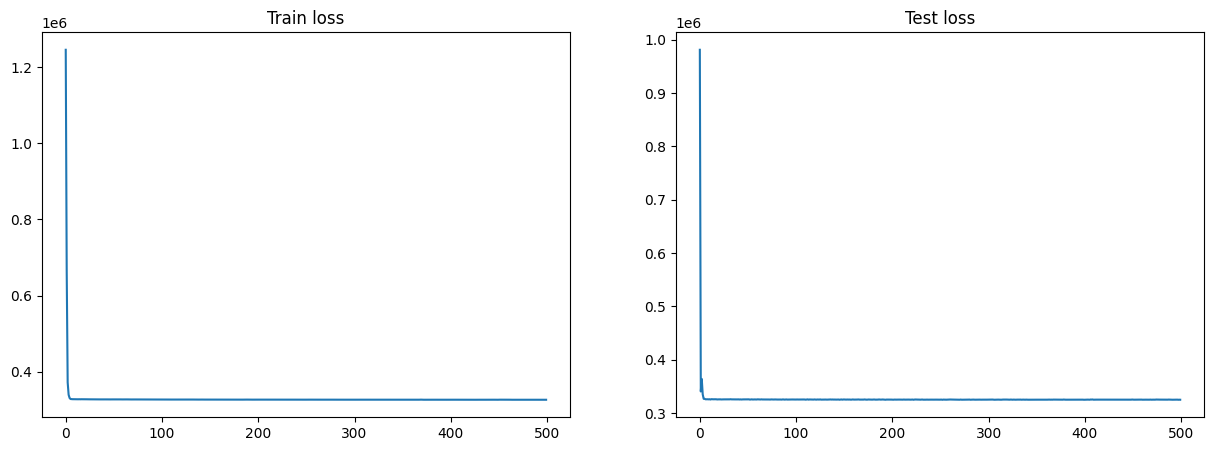

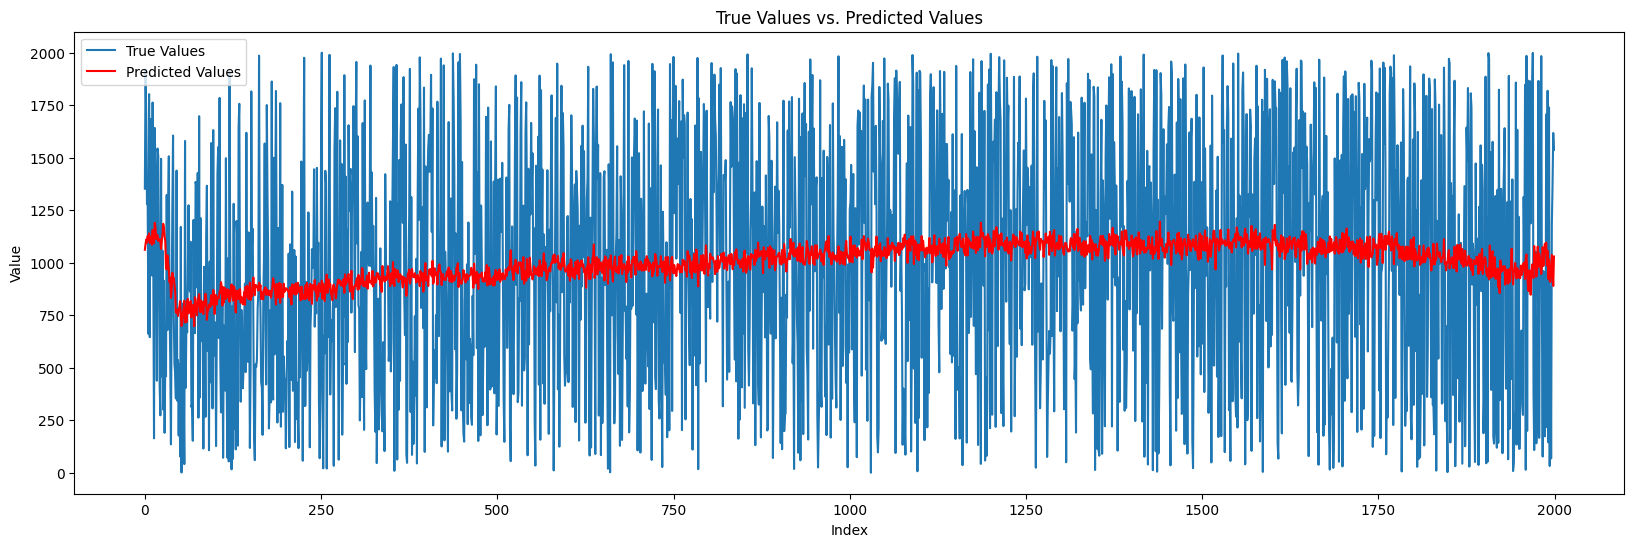

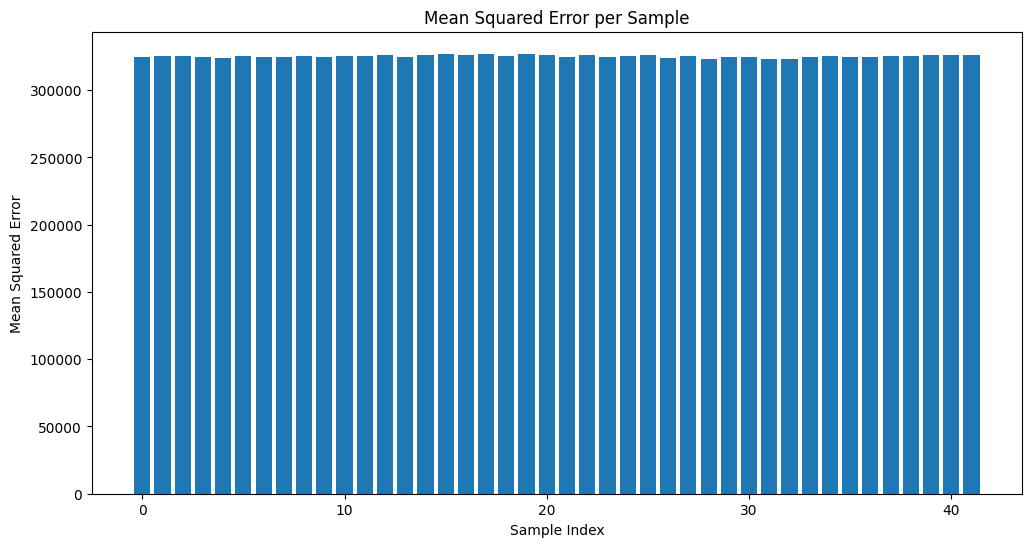

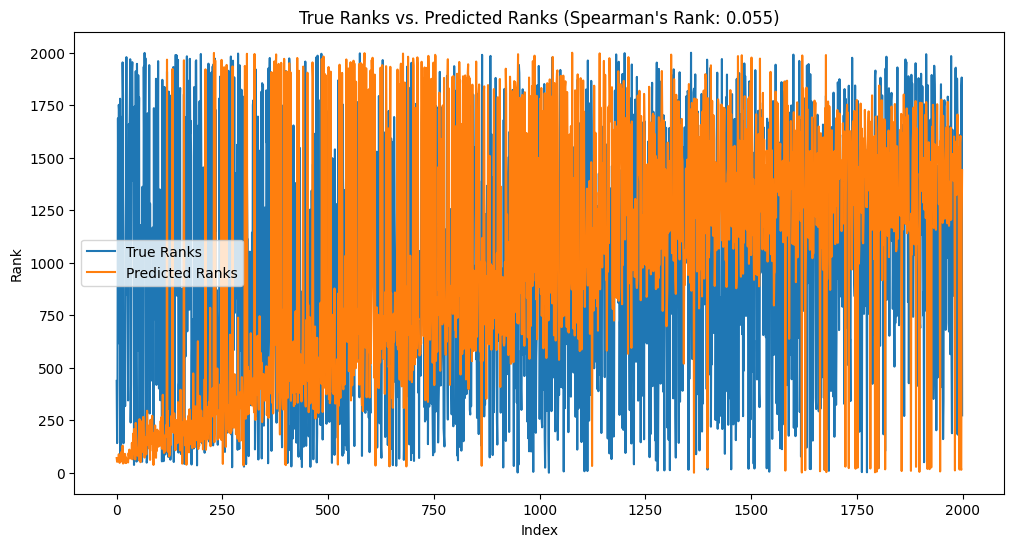

Average Spearman's Rank Correlation: 0.055507367376841844


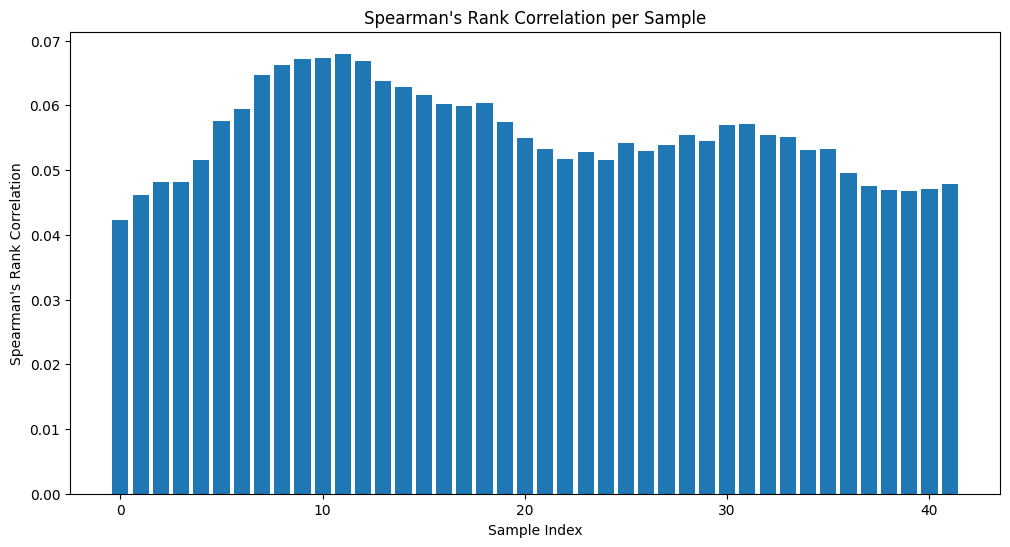

In [ ]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    plt.savefig('sample.png')

plot_history(history) #

pred_y = model.predict(x_test)
sample_index = 0

plt.figure(figsize=(20, 6))
plt.plot(y_test[sample_index], label='True Values')
plt.plot(pred_y[sample_index], label='Predicted Values',color='red')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('True Values vs. Predicted Values')
plt.legend()
plt.show()

y_test = np.array(y_test)
# calculate the MSE for each sample
mse_per_sample = np.mean((y_test - pred_y) ** 2, axis=1)

plt.figure(figsize=(12, 6))
plt.bar(np.arange(y_test.shape[0]), mse_per_sample)
plt.xlabel('Sample Index')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error per Sample')
plt.show()


import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

sample_index = 32

# Get the true and predicted ranks
true_ranks = np.argsort(y_test[sample_index])
predicted_ranks = np.argsort(pred_y[sample_index])

# Calculate the Spearman's rank correlation coefficient
coeff, _ = stats.spearmanr(true_ranks, predicted_ranks)

plt.figure(figsize=(12, 6))
plt.plot(true_ranks, label='True Ranks')
plt.plot(predicted_ranks, label='Predicted Ranks')
plt.xlabel('Index')
plt.ylabel('Rank')
plt.title(f'True Ranks vs. Predicted Ranks (Spearman\'s Rank: {coeff:.3f})')
plt.legend()
plt.show()

coeffs = []
# Calculate the Spearman's rank correlation for each sample
for i in range(y_test.shape[0]):
    true_ranks = np.argsort(y_test[i])
    predicted_ranks = np.argsort(pred_y[i])
    coeff, _ = stats.spearmanr(true_ranks, predicted_ranks)
    coeffs.append(coeff)

# Calculate and print the average Spearman's rank correlation
print("Average Spearman's Rank Correlation:", np.mean(coeffs))

# Visualize the Spearman's rank correlations using a bar chart
plt.figure(figsize=(12, 6))
plt.bar(np.arange(y_test.shape[0]), coeffs)
plt.xlabel('Sample Index')
plt.ylabel('Spearman\'s Rank Correlation')
plt.title('Spearman\'s Rank Correlation per Sample')
plt.show()

# 평가 코드

In [ ]:
import pandas as pd
import numpy as np
from pprint import pprint
##############################
df_test = pd.read_csv('train_additional.csv') ## 2023-05-31 ~ 2023-06-21
df_test=df_test.set_index('일자')
df_test  = df_test.loc['20230531' : '20230621', ['종목코드', '종가'] ]

cc_close = df_test.sort_values(by='일자').groupby( by=['종목코드'])['종가'].apply(list).to_dict()

###############################
df_submission = pd.read_csv('submission2.csv')
cc_rank = df_submission.sort_values(by='순위')['종목코드'].to_list()

np_cc_buy = np.array([ cc_close[cc] for cc in cc_rank[:200] ])
np_cc_sell = np.array([ cc_close[cc] for cc in cc_rank[-200:] ])

assert np_cc_buy.shape[1] == 15

value = {}
value['매매일수'] = 15
value['무위험수익률'] = 0.035
value['총 매수 수익률']  = + np.sum( np_cc_buy [:,-1]/np_cc_buy [:,0]-1.0 )
value['총 공매도 수익률'] = - np.sum( np_cc_sell[:,-1]/np_cc_sell[:,0]-1.0 )
value['총 자산 최종 수익률'] = ( value['총 매수 수익률'] + value['총 공매도 수익률'] ) / 400
value['연율화된 총자산 최종 수익률'] = value['총 자산 최종 수익률'] * 250 / value['매매일수']

profit_day_buy = + ( np_cc_buy [:,1:]/np_cc_buy [:,:-1]-1.0 )
profit_day_sell = - ( np_cc_sell[:,1:]/np_cc_sell[:,:-1]-1.0 )

value['연율화된 일간수익률의 일별 평균'] = ( profit_day_buy + profit_day_sell ).sum(0) * 250 / 400
value['연율화된 일간수익률의 평균'] = np.mean(value['연율화된 일간수익률의 일별 평균'])
value['총자산 일간 수익률 변동성'] = ( np.sum( ( value['연율화된 일간수익률의 일별 평균'] - value['연율화된 일간수익률의 평균'] ) ** 2.0 ) / (15-2) ) ** 0.5
value['샤프지수'] = ( value['연율화된 총자산 최종 수익률'] - value['무위험수익률'] ) / value['총자산 일간 수익률 변동성']

pprint(value['샤프지수'])

print('총자산 일간 수익률 변동성(다른계산법들)',
   value['연율화된 일간수익률의 일별 평균'].std() * np.sqrt(14/13),
   np.concatenate( ( profit_day_buy, profit_day_sell ) ).mean(0).std() * np.sqrt(14/13) * 250
   )


1. jPX 대회 우승자는 선형회귀를 썼으며, 변수는 종가 시가 차이, 고가 저가 평균 그리고 시고저거종의 ZSCORE였다.

2. classification은 2개면 마지막 출력 층으로 가는 activation function을 sigmoid 여러개면 softmax함수를 쓰면 된다.

3. 꼭 one-hot coding이 아니라 그냥 분류를 숫자로 나타내도 된다.

4. 분류 class는 항상 0부터 시작해야 오류가 나지 않는다.

5. int로 class 나타내면 솔실함수를 sparse_categorical_crossentropy, one hot coding이면 손실함수를 categorical_crossentropy로 설정한다.

6. 모델링은 .add 방식이 있고 C = B(A) 방식이 있다.

7. 특징을 인간이 만들어내 학습시킬 수 있고, 그냥 모든 것을 컴퓨터가 학습하도록 만들수 있다.

8. 불량률, 부정 거래 등 전체에서 일부만 차지하는 것을 골라내는 일에는 F1_score를 이용할 수 잇다. 전부 정상으로 분류하면 정답률이 높으니까 다른 점수를 이용

9. 모델 loss가 nan이 나오면 loss가 너무 작거나, 데이터에 NaN inf 등 부적절한 값이 섞여 있을 가능성이 있다.

10. activation function - swish가 새로 나왔다. LSTM에는 보통 tanh가 쓰인다.

 참고할 만한 github
https://github.com/quant4junior/algoTrade/blob/master/ch08/8.2%20RNN%EC%9D%84%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EC%A3%BC%EA%B0%80%20%EB%B0%A9%ED%96%A5%EC%84%B1%20%EB%B6%84%EB%A5%98%20%EC%98%88%EC%B8%A1/8.2%20lstm_prediction_dropout_batchnormal.ipynb


# CF) 최근 정보 가져와서 예측하기

In [ ]:
#라이브러리 설치
!pip install finance-datareader
import finance_datareader as fdr
import pandas as pd

In [ ]:
import FinanceDataReader as fdr
import pandas as pd

df1 = pd.read_csv('/content/train.csv', encoding='cp949')
df1 = df1.pivot(index='일자', columns=['종목코드'], values=['종가'])
df1.columns = df1.columns.map('_'.join).str.strip('_')
df1.index = pd.to_datetime(df1.index,format = '%Y%m%d')


df2= pd.read_csv('/content/train_additional.csv') #, encoding='cp949'
df2 = df2.pivot(index='일자', columns=['종목코드'], values=['종가'])
df2.columns = df2.columns.map('_'.join).str.strip('_')
df2.index = pd.to_datetime(df2.index,format = '%Y%m%d')


df = pd.concat([df1, df2])

df.tail()

In [ ]:

start_date = '2023-07-31'
last_date = '2023-08-09'

new_data = pd.DataFrame(columns=df.columns)
i = 1
for var in df.columns:
    print(i)
    i += 1
    # Remove the first 4 characters and use the modified stock symbol
    modified_var = var[4:]
    data = fdr.DataReader(modified_var, start_date, last_date)
    new_column_name = '종가_A' + modified_var
    data = data.rename(columns={'Close': new_column_name})
    new_data[new_column_name] = data[new_column_name]

# Set the same index name as the original df
new_data.index.name = '일자'

# Concatenate the existing data with the new data
df = pd.concat([df, new_data])

In [58]:
# Finding the location of NaN values
nan_locations = [(index, col) for col in df.columns for index, value in enumerate(df[col]) if pd.isna(value)]

# Printing the location of NaN values (row index, column name)
print("Locations of NaN values:")
for loc in nan_locations:
    print(f"Row index: {loc[0]}, Column: {loc[1]}")

Locations of NaN values:


In [57]:
df = df.fillna(0)

In [ ]:
df.to_csv('data_0809.csv', encoding='cp949')